# LSTM - vanilla

In [67]:
# best_model = "best_model0.pt"
best_model = "best_model0_feat_eng_add_ang_acc_noise_attn.pt"

## Load and prepare data

In [90]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import tqdm

In [68]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


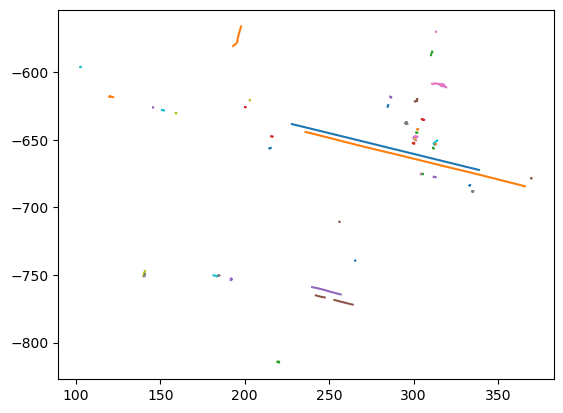

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [6]:
# class TrajectoryDatasetTrain(Dataset):
#     def __init__(self, data, scale=10.0, augment=True):
#         """
#         data: Shape (N, 50, 110, 6) Training data
#         scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
#         augment: Whether to apply data augmentation (only for training)
#         """
#         self.data = data
#         self.scale = scale
#         self.augment = augment

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         scene = self.data[idx]
#         # Getting 50 historical timestamps and 60 future timestamps
#         hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
#         future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
#         # Data augmentation(only for training)
#         if self.augment:
#             if np.random.rand() < 0.5:
#                 theta = np.random.uniform(-np.pi, np.pi)
#                 R = np.array([[np.cos(theta), -np.sin(theta)],
#                               [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
#                 # Rotate the historical trajectory and future trajectory
#                 hist[..., :2] = hist[..., :2] @ R
#                 hist[..., 2:4] = hist[..., 2:4] @ R
#                 future = future @ R
#             if np.random.rand() < 0.5:
#                 hist[..., 0] *= -1
#                 hist[..., 2] *= -1
#                 future[:, 0] *= -1

#         # Use the last timeframe of the historical trajectory as the origin
#         origin = hist[0, 49, :2].copy()  # (2,)
#         hist[..., :2] = hist[..., :2] - origin
#         # future = future - origin

#         # Normalize the historical trajectory and future trajectory
#         hist[..., :4] = hist[..., :4] / self.scale
#         future = future / self.scale

#         data_item = Data(
#             x=torch.tensor(hist, dtype=torch.float32),
#             y=future.type(torch.float32),
#             origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
#             scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
#         )
        
#         # print(f'x: {data_item.x.shape}')
#         # print(f'y: {data_item.y.shape}')

#         return data_item
    

# class TrajectoryDatasetTest(Dataset):
#     def __init__(self, data, scale=10.0):
#         """
#         data: Shape (N, 50, 110, 6) Testing data
#         scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
#         """
#         self.data = data
#         self.scale = scale

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         # Testing data only contains historical trajectory
#         scene = self.data[idx]  # (50, 50, 6)
#         hist = scene.copy()
        
#         origin = hist[0, 49, :2].copy()
#         hist[..., :2] = hist[..., :2] - origin
#         hist[..., :4] = hist[..., :4] / self.scale

#         data_item = Data(
#             x=torch.tensor(hist, dtype=torch.float32),
#             origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
#             scale=torch.tensor(self.scale, dtype=torch.float32),
#         )
#         return data_item

In [117]:
def add_scaled_sensor_noise_per_agent(x, base_std=0.3, eps=1e-9):
    """
    x: Tensor of shape [batch, agents, time, features]
    Adds Gaussian noise with std scaled by agent-specific feature std across time.
    """
    # Compute std over time dimension (dim=2) → shape: [B, A, 1, F]
    std_per_agent = x.std(dim=2, keepdim=True).clamp(min=eps)  # avoid divide-by-zero
    # print('noise')
    # Sample noise scaled by local std
    noise = torch.randn_like(x) * std_per_agent * base_std
    # print('noise done')
    x_noise = x + noise
    return torch.tensor(x_noise, dtype=x.dtype)

In [129]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        self.data = data
        self.scale = scale
        self.augment = augment
        self.dt = 0.1  # seconds

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        hist = scene[:, :50, :4].copy()  # (agents=50, time_seq=50, 5)
        future = torch.tensor(scene[0, 50:, 0:4].copy(), dtype=torch.float32)  # (60, 2)

        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future[..., :2] = future[..., :2] @ R
                future[..., 2:4] = future[..., 2:4] @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1
                future[:, 2] *= -1

        v = hist[..., 2:4]  # velocity
        a = np.zeros_like(v)
        a[..., 1:] = (v[..., 1:] - v[..., :-1]) / self.dt

        theta = np.arctan2(v[..., 1], v[..., 0])[..., np.newaxis]
        omega = np.zeros_like(theta)
        omega[..., 1:] = (theta[..., 1:] - theta[..., :-1]) / self.dt

        alpha = np.zeros_like(omega)
        alpha[..., 1:] = (omega[..., 1:] - omega[..., :-1]) / self.dt

        hist_aug = np.concatenate([hist, a, theta, omega, alpha], axis=-1)  # shape (50, 50, 9)

        origin = hist_aug[0, 49, :2].copy()
        hist_aug[..., :2] -= origin
        hist_aug[..., :4] /= self.scale
        hist_aug[..., 4:6] /= self.scale / self.dt        # ax, ay
        hist_aug[..., 6] /= np.pi                         # θ ∈ [-π, π]
        hist_aug[..., 7] /= (np.pi / self.dt)             # ω
        hist_aug[..., 8] /= (np.pi / (self.dt ** 2))      # α
        future[..., :2] = future[..., :2] - origin
        future = future / self.scale

        # future = add_scaled_sensor_noise_per_agent(future)
        x = torch.tensor(hist_aug, dtype=torch.float32)
        # x = add_scaled_sensor_noise_per_agent(x)

        return Data(
            x=x,
            y=future,
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        
        
class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        self.data = data
        self.scale = scale
        self.dt = 0.1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        hist = self.data[idx][:, :50, :4].copy()  # (50, 50, 4: [x, y, vx, vy])

        v = hist[..., 2:4]
        a = np.zeros_like(v)
        a[..., 1:] = (v[..., 1:] - v[..., :-1]) / self.dt

        theta = np.arctan2(v[..., 1], v[..., 0])[..., np.newaxis]
        omega = np.zeros_like(theta)
        omega[..., 1:] = (theta[..., 1:] - theta[..., :-1]) / self.dt

        alpha = np.zeros_like(omega)
        alpha[..., 1:] = (omega[..., 1:] - omega[..., :-1]) / self.dt

        hist_aug = np.concatenate([hist, a, theta, omega, alpha], axis=-1)  # shape (50, 50, 9)

        origin = hist_aug[0, 49, :2].copy()
        hist_aug[..., :2] -= origin
        print(hist_aug.shape)
        hist_aug[..., :4] /= self.scale
        print(hist_aug.shape)
        hist_aug[..., 4:6] /= self.scale / self.dt
        hist_aug[..., 6] /= np.pi
        hist_aug[..., 7] /= (np.pi / self.dt)
        hist_aug[..., 8] /= (np.pi / (self.dt ** 2))

        return Data(
            x=torch.tensor(hist_aug, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

In [130]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [121]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # 2 layers 9.77 val
    def __init__(self, input_dim=9, hidden_dim=512, output_dim=60*2, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.ego_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8, batch_first=True)
        self.normlayer = nn.LayerNorm(hidden_dim)  
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        # TODO: remove dropout?
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        self.input_dim = input_dim
        
        # Initialize weights properly
        # for name, param in self.named_parameters():
        #     if 'weight' in name:
        #         nn.init.xavier_normal_(param)
        #     elif 'bias' in name:
        #         nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        # x = data.x[..., :5]
        x = data.x.reshape(-1, 50, 50, self.input_dim)  # (batch_size, num_agents, seq_len, input_dim)
        # x = add_scaled_sensor_noise_per_agent(x)
        batch_size = x.size(0)
        # x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # EGO AGENT
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)
        # Process through LSTM
        ego_lstm_out, _ = self.ego_encoder(ego_traj)
        # Extract final hidden state
        ego_features = ego_lstm_out[:, -1, :]
        
        # CLOSEST NEIGHBOR
        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego
        
        _, neighbor_ids = torch.topk(dists, k=1, dim=1, largest=False)  # (batch, 3)
        
        # ---- ENCODE NEIGHBORS ----
        neighbor_out_list = []

        for i in range(1):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b]] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            neighbor_lstm_out, _ = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_out_list.append(neighbor_lstm_out[:, -1, :])
        neighbor_out_list = neighbor_lstm_out[:, -1, :]
        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        # all_features = torch.cat([ego_features] + neighbor_out_list, dim=1)  # (num_layers, batch, hidden_dim * 4)
        q = ego_features.unsqueeze(1)  # (B, 1, D)
        k = v = neighbor_out_list.unsqueeze(1)  # (B, 1, D)
        # print(q.shape, k.shape, v.shape)
        context, _ = self.cross_attn(q, k, v)  # (B, 1, D)
        context = context + q           # (B, 1, D)
        # # print(context.shape)
        context = self.normlayer(context)
        pooled = context.squeeze(1)
        # Process through prediction head
        features = self.relu(self.fc1(pooled))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [122]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y_all  = batch.y.view(batch.num_graphs, 60, 4)
            y = y_all[..., 2:4]
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y_all  = batch.y.view(batch.num_graphs, 60, 4)
                y = y_all[..., 2:4]
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [123]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.001,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # # Evaluate
    # model.eval()
    # test_mse = 0
    # with torch.no_grad():
    #     for batch in val_dataloader:
    #         batch = batch.to(device)
    #         pred = model(batch)
    #         y = batch.y.view(batch.num_graphs, 60, 2)
            
    #         # Unnormalize
    #         pred = pred * batch.scale.view(-1, 1, 1)
    #         y = y * batch.scale.view(-1, 1, 1)
            
    #         test_mse += nn.MSELoss()(pred, y).item()
    
    # test_mse /= len(val_dataloader)
    # print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [124]:
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/2383651072.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/2383651072.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/2383651072.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
Epoch:   1%|          | 1/150 [00:13<33:44, 13.59s/epoch]

Epoch 000 | LR 0.000950 | Train MSE 0.1001 | Val MSE 0.0757 | Val MAE 1.2399 | Val MSE 3.7104
Sample pred first 3 steps: [[-0.05518414  0.0106341 ]
 [-0.01216175 -0.01535671]
 [ 0.00040091 -0.02999319]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.075722


Epoch:   1%|▏         | 2/150 [00:27<33:18, 13.50s/epoch]

Epoch 001 | LR 0.000902 | Train MSE 0.0806 | Val MSE 0.0641 | Val MAE 1.1063 | Val MSE 3.1390
Validation improved: 0.075722 -> 0.064060


Epoch:   2%|▏         | 3/150 [00:40<32:53, 13.42s/epoch]

Epoch 002 | LR 0.000857 | Train MSE 0.0697 | Val MSE 0.0606 | Val MAE 1.0419 | Val MSE 2.9676
Validation improved: 0.064060 -> 0.060564


Epoch:   3%|▎         | 4/150 [00:54<33:12, 13.64s/epoch]

Epoch 003 | LR 0.000815 | Train MSE 0.0649 | Val MSE 0.0557 | Val MAE 1.0494 | Val MSE 2.7291
Validation improved: 0.060564 -> 0.055697


Epoch:   3%|▎         | 5/150 [01:08<33:05, 13.69s/epoch]

Epoch 004 | LR 0.000774 | Train MSE 0.0612 | Val MSE 0.0526 | Val MAE 0.9990 | Val MSE 2.5790
Validation improved: 0.055697 -> 0.052632


Epoch:   4%|▍         | 6/150 [01:21<32:43, 13.64s/epoch]

Epoch 005 | LR 0.000735 | Train MSE 0.0561 | Val MSE 0.0500 | Val MAE 0.9524 | Val MSE 2.4491
Sample pred first 3 steps: [[-0.00583536  0.00807159]
 [-0.0057928   0.00570165]
 [-0.00792761  0.00802769]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.052632 -> 0.049982


Epoch:   5%|▍         | 7/150 [01:40<36:40, 15.39s/epoch]

Epoch 006 | LR 0.000698 | Train MSE 0.0544 | Val MSE 0.0528 | Val MAE 1.0184 | Val MSE 2.5857


Epoch:   5%|▌         | 8/150 [01:57<37:45, 15.95s/epoch]

Epoch 007 | LR 0.000663 | Train MSE 0.0529 | Val MSE 0.0539 | Val MAE 1.0158 | Val MSE 2.6398


Epoch:   6%|▌         | 9/150 [02:13<37:38, 16.02s/epoch]

Epoch 008 | LR 0.000630 | Train MSE 0.0513 | Val MSE 0.0488 | Val MAE 0.9408 | Val MSE 2.3893
Validation improved: 0.049982 -> 0.048762


Epoch:   7%|▋         | 10/150 [02:30<37:28, 16.06s/epoch]

Epoch 009 | LR 0.000599 | Train MSE 0.0509 | Val MSE 0.0437 | Val MAE 0.8765 | Val MSE 2.1434
Validation improved: 0.048762 -> 0.043742


Epoch:   7%|▋         | 11/150 [02:46<37:20, 16.12s/epoch]

Epoch 010 | LR 0.000569 | Train MSE 0.0491 | Val MSE 0.0471 | Val MAE 0.9017 | Val MSE 2.3081
Sample pred first 3 steps: [[-0.02320222  0.03201721]
 [-0.02085048  0.03124445]
 [-0.01884881  0.02864312]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [03:02<37:19, 16.23s/epoch]

Epoch 011 | LR 0.000540 | Train MSE 0.0485 | Val MSE 0.0432 | Val MAE 0.8732 | Val MSE 2.1182
Validation improved: 0.043742 -> 0.043229


Epoch:   9%|▊         | 13/150 [03:21<38:47, 16.99s/epoch]

Epoch 012 | LR 0.000513 | Train MSE 0.0470 | Val MSE 0.0429 | Val MAE 0.8786 | Val MSE 2.1014
Validation improved: 0.043229 -> 0.042885


Epoch:   9%|▉         | 14/150 [03:37<37:39, 16.62s/epoch]

Epoch 013 | LR 0.000488 | Train MSE 0.0472 | Val MSE 0.0412 | Val MAE 0.7989 | Val MSE 2.0195
Validation improved: 0.042885 -> 0.041215


Epoch:  10%|█         | 15/150 [03:58<40:16, 17.90s/epoch]

Epoch 014 | LR 0.000463 | Train MSE 0.0457 | Val MSE 0.0422 | Val MAE 0.8348 | Val MSE 2.0680


Epoch:  11%|█         | 16/150 [04:23<44:37, 19.98s/epoch]

Epoch 015 | LR 0.000440 | Train MSE 0.0462 | Val MSE 0.0420 | Val MAE 0.8061 | Val MSE 2.0573
Sample pred first 3 steps: [[-0.03003863  0.01957183]
 [-0.02963314  0.0189372 ]
 [-0.02950104  0.01821425]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  11%|█▏        | 17/150 [04:46<46:53, 21.16s/epoch]

Epoch 016 | LR 0.000418 | Train MSE 0.0454 | Val MSE 0.0413 | Val MAE 0.8215 | Val MSE 2.0251


Epoch:  12%|█▏        | 18/150 [05:10<47:55, 21.78s/epoch]

Epoch 017 | LR 0.000397 | Train MSE 0.0457 | Val MSE 0.0402 | Val MAE 0.7950 | Val MSE 1.9714
Validation improved: 0.041215 -> 0.040234


Epoch:  13%|█▎        | 19/150 [05:28<45:34, 20.87s/epoch]

Epoch 018 | LR 0.000377 | Train MSE 0.0443 | Val MSE 0.0401 | Val MAE 0.7880 | Val MSE 1.9671
Validation improved: 0.040234 -> 0.040145


Epoch:  13%|█▎        | 20/150 [05:48<44:03, 20.34s/epoch]

Epoch 019 | LR 0.000358 | Train MSE 0.0440 | Val MSE 0.0397 | Val MAE 0.8111 | Val MSE 1.9461
Validation improved: 0.040145 -> 0.039716


Epoch:  14%|█▍        | 21/150 [06:04<41:30, 19.30s/epoch]

Epoch 020 | LR 0.000341 | Train MSE 0.0440 | Val MSE 0.0404 | Val MAE 0.7997 | Val MSE 1.9783
Sample pred first 3 steps: [[ 0.0225369  -0.0022264 ]
 [ 0.02237687 -0.00159054]
 [ 0.02316688 -0.00325411]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  15%|█▍        | 22/150 [06:21<39:38, 18.58s/epoch]

Epoch 021 | LR 0.000324 | Train MSE 0.0435 | Val MSE 0.0390 | Val MAE 0.7815 | Val MSE 1.9088
Validation improved: 0.039716 -> 0.038954


Epoch:  15%|█▌        | 23/150 [06:37<37:47, 17.86s/epoch]

Epoch 022 | LR 0.000307 | Train MSE 0.0431 | Val MSE 0.0399 | Val MAE 0.7936 | Val MSE 1.9553


Epoch:  16%|█▌        | 24/150 [06:53<36:15, 17.27s/epoch]

Epoch 023 | LR 0.000292 | Train MSE 0.0429 | Val MSE 0.0397 | Val MAE 0.7956 | Val MSE 1.9453


Epoch:  17%|█▋        | 25/150 [07:09<34:47, 16.70s/epoch]

Epoch 024 | LR 0.000277 | Train MSE 0.0428 | Val MSE 0.0374 | Val MAE 0.7406 | Val MSE 1.8319
Validation improved: 0.038954 -> 0.037386


Epoch:  17%|█▋        | 26/150 [07:23<33:10, 16.05s/epoch]

Epoch 025 | LR 0.000264 | Train MSE 0.0421 | Val MSE 0.0383 | Val MAE 0.7769 | Val MSE 1.8760
Sample pred first 3 steps: [[-0.00111688 -0.01503198]
 [-0.00161712 -0.01584844]
 [-0.00159472 -0.01547882]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  18%|█▊        | 27/150 [07:38<32:00, 15.61s/epoch]

Epoch 026 | LR 0.000250 | Train MSE 0.0422 | Val MSE 0.0392 | Val MAE 0.7777 | Val MSE 1.9186


Epoch:  19%|█▊        | 28/150 [07:54<32:00, 15.74s/epoch]

Epoch 027 | LR 0.000238 | Train MSE 0.0419 | Val MSE 0.0390 | Val MAE 0.7605 | Val MSE 1.9119


Epoch:  19%|█▉        | 29/150 [08:09<31:19, 15.53s/epoch]

Epoch 028 | LR 0.000226 | Train MSE 0.0417 | Val MSE 0.0383 | Val MAE 0.7523 | Val MSE 1.8745


Epoch:  20%|██        | 30/150 [08:23<30:24, 15.21s/epoch]

Epoch 029 | LR 0.000215 | Train MSE 0.0414 | Val MSE 0.0388 | Val MAE 0.7709 | Val MSE 1.8997


Epoch:  21%|██        | 31/150 [08:38<29:43, 14.99s/epoch]

Epoch 030 | LR 0.000204 | Train MSE 0.0411 | Val MSE 0.0391 | Val MAE 0.7869 | Val MSE 1.9151
Sample pred first 3 steps: [[0.00849746 0.04224597]
 [0.00969307 0.04227545]
 [0.01104826 0.04262071]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [08:53<29:32, 15.02s/epoch]

Epoch 031 | LR 0.000194 | Train MSE 0.0405 | Val MSE 0.0386 | Val MAE 0.7677 | Val MSE 1.8907


Epoch:  22%|██▏       | 33/150 [09:08<29:14, 15.00s/epoch]

Epoch 032 | LR 0.000184 | Train MSE 0.0404 | Val MSE 0.0377 | Val MAE 0.7522 | Val MSE 1.8466


Epoch:  23%|██▎       | 34/150 [09:23<28:52, 14.94s/epoch]

Epoch 033 | LR 0.000175 | Train MSE 0.0403 | Val MSE 0.0375 | Val MAE 0.7535 | Val MSE 1.8386


Epoch:  23%|██▎       | 35/150 [09:38<28:49, 15.04s/epoch]

Epoch 034 | LR 0.000166 | Train MSE 0.0404 | Val MSE 0.0384 | Val MAE 0.7489 | Val MSE 1.8810


Epoch:  24%|██▍       | 36/150 [09:53<28:21, 14.93s/epoch]

Epoch 035 | LR 0.000158 | Train MSE 0.0399 | Val MSE 0.0371 | Val MAE 0.7435 | Val MSE 1.8189
Sample pred first 3 steps: [[-0.01195749  0.00584332]
 [-0.01154214  0.0063876 ]
 [-0.01060289  0.00704112]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.037386 -> 0.037120


Epoch:  25%|██▍       | 37/150 [10:07<27:48, 14.76s/epoch]

Epoch 036 | LR 0.000150 | Train MSE 0.0396 | Val MSE 0.0367 | Val MAE 0.7318 | Val MSE 1.7959
Validation improved: 0.037120 -> 0.036652


Epoch:  25%|██▌       | 38/150 [10:22<27:24, 14.68s/epoch]

Epoch 037 | LR 0.000142 | Train MSE 0.0400 | Val MSE 0.0372 | Val MAE 0.7351 | Val MSE 1.8229


Epoch:  26%|██▌       | 39/150 [10:36<27:02, 14.62s/epoch]

Epoch 038 | LR 0.000135 | Train MSE 0.0395 | Val MSE 0.0364 | Val MAE 0.7122 | Val MSE 1.7829
Validation improved: 0.036652 -> 0.036386


Epoch:  27%|██▋       | 40/150 [10:51<26:46, 14.60s/epoch]

Epoch 039 | LR 0.000129 | Train MSE 0.0395 | Val MSE 0.0368 | Val MAE 0.7222 | Val MSE 1.8018


Epoch:  27%|██▋       | 41/150 [11:05<26:35, 14.63s/epoch]

Epoch 040 | LR 0.000122 | Train MSE 0.0396 | Val MSE 0.0368 | Val MAE 0.7211 | Val MSE 1.8022
Sample pred first 3 steps: [[0.00102415 0.02191872]
 [0.00168387 0.02103076]
 [0.00278975 0.02053412]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  28%|██▊       | 42/150 [11:20<26:18, 14.61s/epoch]

Epoch 041 | LR 0.000116 | Train MSE 0.0394 | Val MSE 0.0363 | Val MAE 0.7125 | Val MSE 1.7799
Validation improved: 0.036386 -> 0.036324


Epoch:  29%|██▊       | 43/150 [11:34<25:54, 14.53s/epoch]

Epoch 042 | LR 0.000110 | Train MSE 0.0392 | Val MSE 0.0360 | Val MAE 0.7029 | Val MSE 1.7652
Validation improved: 0.036324 -> 0.036025


Epoch:  29%|██▉       | 44/150 [11:49<25:35, 14.49s/epoch]

Epoch 043 | LR 0.000105 | Train MSE 0.0388 | Val MSE 0.0366 | Val MAE 0.7190 | Val MSE 1.7952


Epoch:  30%|███       | 45/150 [12:04<25:44, 14.71s/epoch]

Epoch 044 | LR 0.000099 | Train MSE 0.0387 | Val MSE 0.0359 | Val MAE 0.7055 | Val MSE 1.7600
Validation improved: 0.036025 -> 0.035919


Epoch:  31%|███       | 46/150 [12:20<26:13, 15.13s/epoch]

Epoch 045 | LR 0.000094 | Train MSE 0.0389 | Val MSE 0.0364 | Val MAE 0.7161 | Val MSE 1.7819
Sample pred first 3 steps: [[-0.01305423  0.0051092 ]
 [-0.01280039  0.00478175]
 [-0.01278852  0.00434127]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [12:35<25:45, 15.00s/epoch]

Epoch 046 | LR 0.000090 | Train MSE 0.0387 | Val MSE 0.0365 | Val MAE 0.7272 | Val MSE 1.7883


Epoch:  32%|███▏      | 48/150 [12:49<25:13, 14.84s/epoch]

Epoch 047 | LR 0.000085 | Train MSE 0.0383 | Val MSE 0.0356 | Val MAE 0.7043 | Val MSE 1.7463
Validation improved: 0.035919 -> 0.035638


Epoch:  33%|███▎      | 49/150 [13:04<24:47, 14.73s/epoch]

Epoch 048 | LR 0.000081 | Train MSE 0.0384 | Val MSE 0.0360 | Val MAE 0.7156 | Val MSE 1.7634


Epoch:  33%|███▎      | 50/150 [13:18<24:25, 14.65s/epoch]

Epoch 049 | LR 0.000077 | Train MSE 0.0382 | Val MSE 0.0358 | Val MAE 0.7117 | Val MSE 1.7550


Epoch:  34%|███▍      | 51/150 [13:33<24:10, 14.65s/epoch]

Epoch 050 | LR 0.000073 | Train MSE 0.0377 | Val MSE 0.0366 | Val MAE 0.7316 | Val MSE 1.7942
Sample pred first 3 steps: [[-3.1716745e-02  9.8189677e-04]
 [-3.0456077e-02 -1.8186984e-05]
 [-2.9133029e-02  3.0600931e-06]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  35%|███▍      | 52/150 [13:47<23:51, 14.61s/epoch]

Epoch 051 | LR 0.000069 | Train MSE 0.0382 | Val MSE 0.0361 | Val MAE 0.7209 | Val MSE 1.7701


Epoch:  35%|███▌      | 53/150 [14:02<23:32, 14.56s/epoch]

Epoch 052 | LR 0.000066 | Train MSE 0.0377 | Val MSE 0.0358 | Val MAE 0.7088 | Val MSE 1.7547


Epoch:  36%|███▌      | 54/150 [14:16<23:17, 14.56s/epoch]

Epoch 053 | LR 0.000063 | Train MSE 0.0379 | Val MSE 0.0361 | Val MAE 0.7207 | Val MSE 1.7679


Epoch:  37%|███▋      | 55/150 [14:31<23:02, 14.56s/epoch]

Epoch 054 | LR 0.000060 | Train MSE 0.0377 | Val MSE 0.0357 | Val MAE 0.7033 | Val MSE 1.7474


Epoch:  37%|███▋      | 56/150 [14:45<22:45, 14.53s/epoch]

Epoch 055 | LR 0.000057 | Train MSE 0.0377 | Val MSE 0.0357 | Val MAE 0.7037 | Val MSE 1.7505
Sample pred first 3 steps: [[-0.01791763  0.00438591]
 [-0.01750036  0.0039051 ]
 [-0.01725182  0.00387132]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  38%|███▊      | 57/150 [15:00<22:28, 14.50s/epoch]

Epoch 056 | LR 0.000054 | Train MSE 0.0377 | Val MSE 0.0356 | Val MAE 0.7125 | Val MSE 1.7428
Validation improved: 0.035638 -> 0.035567


Epoch:  39%|███▊      | 58/150 [15:14<22:15, 14.52s/epoch]

Epoch 057 | LR 0.000051 | Train MSE 0.0374 | Val MSE 0.0357 | Val MAE 0.7122 | Val MSE 1.7505


Epoch:  39%|███▉      | 59/150 [15:29<22:03, 14.54s/epoch]

Epoch 058 | LR 0.000048 | Train MSE 0.0373 | Val MSE 0.0352 | Val MAE 0.7060 | Val MSE 1.7268
Validation improved: 0.035567 -> 0.035240


Epoch:  40%|████      | 60/150 [15:43<21:50, 14.56s/epoch]

Epoch 059 | LR 0.000046 | Train MSE 0.0376 | Val MSE 0.0350 | Val MAE 0.6901 | Val MSE 1.7172
Validation improved: 0.035240 -> 0.035046


Epoch:  41%|████      | 61/150 [15:58<21:34, 14.55s/epoch]

Epoch 060 | LR 0.000044 | Train MSE 0.0372 | Val MSE 0.0355 | Val MAE 0.6973 | Val MSE 1.7402
Sample pred first 3 steps: [[-0.01284914  0.01136995]
 [-0.01257559  0.00977619]
 [-0.01200784  0.00902324]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████▏     | 62/150 [16:12<21:19, 14.54s/epoch]

Epoch 061 | LR 0.000042 | Train MSE 0.0373 | Val MSE 0.0353 | Val MAE 0.6978 | Val MSE 1.7287


Epoch:  42%|████▏     | 63/150 [16:27<21:09, 14.59s/epoch]

Epoch 062 | LR 0.000039 | Train MSE 0.0372 | Val MSE 0.0354 | Val MAE 0.7083 | Val MSE 1.7345


Epoch:  43%|████▎     | 64/150 [16:42<20:53, 14.58s/epoch]

Epoch 063 | LR 0.000038 | Train MSE 0.0372 | Val MSE 0.0354 | Val MAE 0.7065 | Val MSE 1.7361


Epoch:  43%|████▎     | 65/150 [16:56<20:38, 14.57s/epoch]

Epoch 064 | LR 0.000036 | Train MSE 0.0369 | Val MSE 0.0354 | Val MAE 0.7021 | Val MSE 1.7346


Epoch:  44%|████▍     | 66/150 [17:11<20:27, 14.61s/epoch]

Epoch 065 | LR 0.000034 | Train MSE 0.0369 | Val MSE 0.0355 | Val MAE 0.7062 | Val MSE 1.7382
Sample pred first 3 steps: [[-2.7962200e-02  5.7877135e-04]
 [-2.6863512e-02 -4.7558686e-05]
 [-2.5893852e-02 -1.4762790e-04]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  45%|████▍     | 67/150 [17:25<20:11, 14.60s/epoch]

Epoch 066 | LR 0.000032 | Train MSE 0.0370 | Val MSE 0.0351 | Val MAE 0.6966 | Val MSE 1.7214


Epoch:  45%|████▌     | 68/150 [17:40<19:53, 14.56s/epoch]

Epoch 067 | LR 0.000031 | Train MSE 0.0371 | Val MSE 0.0352 | Val MAE 0.7063 | Val MSE 1.7244


Epoch:  46%|████▌     | 69/150 [17:54<19:38, 14.55s/epoch]

Epoch 068 | LR 0.000029 | Train MSE 0.0368 | Val MSE 0.0354 | Val MAE 0.7049 | Val MSE 1.7328


Epoch:  47%|████▋     | 70/150 [18:09<19:30, 14.63s/epoch]

Epoch 069 | LR 0.000028 | Train MSE 0.0364 | Val MSE 0.0355 | Val MAE 0.7037 | Val MSE 1.7392


Epoch:  47%|████▋     | 71/150 [18:24<19:11, 14.58s/epoch]

Epoch 070 | LR 0.000026 | Train MSE 0.0368 | Val MSE 0.0354 | Val MAE 0.7041 | Val MSE 1.7345
Sample pred first 3 steps: [[-0.01284113  0.00272494]
 [-0.01242729  0.00192815]
 [-0.01192071  0.0015467 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  48%|████▊     | 72/150 [18:38<18:52, 14.52s/epoch]

Epoch 071 | LR 0.000025 | Train MSE 0.0365 | Val MSE 0.0353 | Val MAE 0.6957 | Val MSE 1.7279


Epoch:  49%|████▊     | 73/150 [18:53<18:36, 14.49s/epoch]

Epoch 072 | LR 0.000024 | Train MSE 0.0367 | Val MSE 0.0349 | Val MAE 0.6934 | Val MSE 1.7084
Validation improved: 0.035046 -> 0.034866


Epoch:  49%|████▉     | 74/150 [19:07<18:24, 14.53s/epoch]

Epoch 073 | LR 0.000022 | Train MSE 0.0362 | Val MSE 0.0354 | Val MAE 0.7071 | Val MSE 1.7339


Epoch:  50%|█████     | 75/150 [19:22<18:07, 14.50s/epoch]

Epoch 074 | LR 0.000021 | Train MSE 0.0367 | Val MSE 0.0349 | Val MAE 0.6922 | Val MSE 1.7125


Epoch:  51%|█████     | 76/150 [19:36<17:52, 14.50s/epoch]

Epoch 075 | LR 0.000020 | Train MSE 0.0367 | Val MSE 0.0348 | Val MAE 0.6868 | Val MSE 1.7075
Sample pred first 3 steps: [[-0.01965544  0.00015175]
 [-0.01885355 -0.00066547]
 [-0.01787616 -0.00102806]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034866 -> 0.034848


Epoch:  51%|█████▏    | 77/150 [19:50<17:34, 14.45s/epoch]

Epoch 076 | LR 0.000019 | Train MSE 0.0366 | Val MSE 0.0351 | Val MAE 0.6967 | Val MSE 1.7176


Epoch:  52%|█████▏    | 78/150 [20:05<17:23, 14.49s/epoch]

Epoch 077 | LR 0.000018 | Train MSE 0.0365 | Val MSE 0.0350 | Val MAE 0.7005 | Val MSE 1.7170


Epoch:  53%|█████▎    | 79/150 [20:20<17:09, 14.50s/epoch]

Epoch 078 | LR 0.000017 | Train MSE 0.0363 | Val MSE 0.0351 | Val MAE 0.7001 | Val MSE 1.7193


Epoch:  53%|█████▎    | 80/150 [20:34<16:55, 14.51s/epoch]

Epoch 079 | LR 0.000017 | Train MSE 0.0362 | Val MSE 0.0347 | Val MAE 0.6920 | Val MSE 1.7007
Validation improved: 0.034848 -> 0.034709


Epoch:  54%|█████▍    | 81/150 [20:49<16:42, 14.52s/epoch]

Epoch 080 | LR 0.000016 | Train MSE 0.0365 | Val MSE 0.0350 | Val MAE 0.6966 | Val MSE 1.7139
Sample pred first 3 steps: [[-0.0146185  -0.00085671]
 [-0.01420761 -0.0015998 ]
 [-0.0137358  -0.00196951]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [21:03<16:29, 14.55s/epoch]

Epoch 081 | LR 0.000015 | Train MSE 0.0363 | Val MSE 0.0350 | Val MAE 0.6970 | Val MSE 1.7166


Epoch:  55%|█████▌    | 83/150 [21:18<16:13, 14.53s/epoch]

Epoch 082 | LR 0.000014 | Train MSE 0.0364 | Val MSE 0.0350 | Val MAE 0.6979 | Val MSE 1.7138


Epoch:  56%|█████▌    | 84/150 [21:32<15:59, 14.54s/epoch]

Epoch 083 | LR 0.000013 | Train MSE 0.0362 | Val MSE 0.0350 | Val MAE 0.6932 | Val MSE 1.7172


Epoch:  57%|█████▋    | 85/150 [21:47<15:44, 14.53s/epoch]

Epoch 084 | LR 0.000013 | Train MSE 0.0360 | Val MSE 0.0349 | Val MAE 0.6956 | Val MSE 1.7105


Epoch:  57%|█████▋    | 86/150 [22:01<15:29, 14.53s/epoch]

Epoch 085 | LR 0.000012 | Train MSE 0.0364 | Val MSE 0.0348 | Val MAE 0.6934 | Val MSE 1.7061
Sample pred first 3 steps: [[-0.02118039 -0.00562208]
 [-0.02059091 -0.00639174]
 [-0.0197751  -0.00674241]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [22:16<15:15, 14.53s/epoch]

Epoch 086 | LR 0.000012 | Train MSE 0.0362 | Val MSE 0.0349 | Val MAE 0.6970 | Val MSE 1.7119


Epoch:  59%|█████▊    | 88/150 [22:30<15:01, 14.55s/epoch]

Epoch 087 | LR 0.000011 | Train MSE 0.0360 | Val MSE 0.0350 | Val MAE 0.6950 | Val MSE 1.7131


Epoch:  59%|█████▉    | 89/150 [22:45<14:46, 14.54s/epoch]

Epoch 088 | LR 0.000010 | Train MSE 0.0359 | Val MSE 0.0349 | Val MAE 0.6955 | Val MSE 1.7086


Epoch:  60%|██████    | 90/150 [23:00<14:32, 14.55s/epoch]

Epoch 089 | LR 0.000010 | Train MSE 0.0363 | Val MSE 0.0348 | Val MAE 0.6916 | Val MSE 1.7064


Epoch:  61%|██████    | 91/150 [23:15<14:35, 14.84s/epoch]

Epoch 090 | LR 0.000009 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6962 | Val MSE 1.7064
Sample pred first 3 steps: [[-0.01994191 -0.01115143]
 [-0.01940191 -0.01149216]
 [-0.01870396 -0.01159071]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  61%|██████▏   | 92/150 [23:35<15:46, 16.32s/epoch]

Epoch 091 | LR 0.000009 | Train MSE 0.0358 | Val MSE 0.0348 | Val MAE 0.6973 | Val MSE 1.7056


Epoch:  62%|██████▏   | 93/150 [23:49<14:51, 15.63s/epoch]

Epoch 092 | LR 0.000008 | Train MSE 0.0359 | Val MSE 0.0348 | Val MAE 0.6954 | Val MSE 1.7038


Epoch:  63%|██████▎   | 94/150 [24:03<14:08, 15.15s/epoch]

Epoch 093 | LR 0.000008 | Train MSE 0.0363 | Val MSE 0.0348 | Val MAE 0.6914 | Val MSE 1.7055


Epoch:  63%|██████▎   | 95/150 [39:35<4:25:55, 290.11s/epoch]

Epoch 094 | LR 0.000008 | Train MSE 0.0358 | Val MSE 0.0347 | Val MAE 0.6953 | Val MSE 1.7027


Epoch:  64%|██████▍   | 96/150 [39:49<3:06:37, 207.36s/epoch]

Epoch 095 | LR 0.000007 | Train MSE 0.0361 | Val MSE 0.0347 | Val MAE 0.6926 | Val MSE 1.7006
Sample pred first 3 steps: [[-0.01778397 -0.00853469]
 [-0.01718996 -0.00899731]
 [-0.01643896 -0.00911696]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034709 -> 0.034705


Epoch:  65%|██████▍   | 97/150 [40:04<2:12:18, 149.78s/epoch]

Epoch 096 | LR 0.000007 | Train MSE 0.0359 | Val MSE 0.0347 | Val MAE 0.6909 | Val MSE 1.6993
Validation improved: 0.034705 -> 0.034680


Epoch:  65%|██████▌   | 98/150 [40:20<1:34:51, 109.46s/epoch]

Epoch 097 | LR 0.000007 | Train MSE 0.0360 | Val MSE 0.0347 | Val MAE 0.6892 | Val MSE 1.6981
Validation improved: 0.034680 -> 0.034655


Epoch:  66%|██████▌   | 99/150 [40:34<1:08:50, 80.99s/epoch] 

Epoch 098 | LR 0.000006 | Train MSE 0.0361 | Val MSE 0.0347 | Val MAE 0.6921 | Val MSE 1.7024


Epoch:  67%|██████▋   | 100/150 [40:49<50:53, 61.08s/epoch] 

Epoch 099 | LR 0.000006 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6938 | Val MSE 1.7058


Epoch:  67%|██████▋   | 101/150 [41:03<38:27, 47.09s/epoch]

Epoch 100 | LR 0.000006 | Train MSE 0.0357 | Val MSE 0.0348 | Val MAE 0.6937 | Val MSE 1.7067
Sample pred first 3 steps: [[-0.01851344 -0.0077446 ]
 [-0.01800422 -0.00822185]
 [-0.01723894 -0.00830884]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [41:18<29:52, 37.34s/epoch]

Epoch 101 | LR 0.000005 | Train MSE 0.0361 | Val MSE 0.0348 | Val MAE 0.6956 | Val MSE 1.7063


Epoch:  69%|██████▊   | 103/150 [41:32<23:53, 30.50s/epoch]

Epoch 102 | LR 0.000005 | Train MSE 0.0361 | Val MSE 0.0349 | Val MAE 0.6933 | Val MSE 1.7078


Epoch:  69%|██████▉   | 104/150 [41:47<19:43, 25.72s/epoch]

Epoch 103 | LR 0.000005 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6915 | Val MSE 1.7058


Epoch:  70%|███████   | 105/150 [42:02<16:48, 22.40s/epoch]

Epoch 104 | LR 0.000005 | Train MSE 0.0357 | Val MSE 0.0349 | Val MAE 0.6948 | Val MSE 1.7118


Epoch:  71%|███████   | 106/150 [42:16<14:43, 20.07s/epoch]

Epoch 105 | LR 0.000004 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6933 | Val MSE 1.7065
Sample pred first 3 steps: [[-0.02026248 -0.009961  ]
 [-0.01964479 -0.01041051]
 [-0.01877257 -0.01052566]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  71%|███████▏  | 107/150 [42:31<13:12, 18.44s/epoch]

Epoch 106 | LR 0.000004 | Train MSE 0.0357 | Val MSE 0.0347 | Val MAE 0.6901 | Val MSE 1.7021


Epoch:  72%|███████▏  | 108/150 [42:45<12:05, 17.27s/epoch]

Epoch 107 | LR 0.000004 | Train MSE 0.0359 | Val MSE 0.0347 | Val MAE 0.6919 | Val MSE 1.7022


Epoch:  73%|███████▎  | 109/150 [43:00<11:15, 16.47s/epoch]

Epoch 108 | LR 0.000004 | Train MSE 0.0358 | Val MSE 0.0347 | Val MAE 0.6903 | Val MSE 1.7016


Epoch:  73%|███████▎  | 110/150 [43:15<10:35, 15.90s/epoch]

Epoch 109 | LR 0.000004 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6922 | Val MSE 1.7036


Epoch:  74%|███████▍  | 111/150 [43:29<10:04, 15.50s/epoch]

Epoch 110 | LR 0.000003 | Train MSE 0.0357 | Val MSE 0.0348 | Val MAE 0.6929 | Val MSE 1.7029
Sample pred first 3 steps: [[-0.01752533 -0.00869744]
 [-0.01704501 -0.00913722]
 [-0.01630589 -0.00922686]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  75%|███████▍  | 112/150 [43:44<09:36, 15.17s/epoch]

Epoch 111 | LR 0.000003 | Train MSE 0.0358 | Val MSE 0.0347 | Val MAE 0.6907 | Val MSE 1.7016


Epoch:  75%|███████▌  | 113/150 [43:58<09:14, 14.98s/epoch]

Epoch 112 | LR 0.000003 | Train MSE 0.0361 | Val MSE 0.0347 | Val MAE 0.6885 | Val MSE 1.7018


Epoch:  76%|███████▌  | 114/150 [44:13<08:55, 14.87s/epoch]

Epoch 113 | LR 0.000003 | Train MSE 0.0360 | Val MSE 0.0347 | Val MAE 0.6899 | Val MSE 1.7020


Epoch:  77%|███████▋  | 115/150 [44:27<08:37, 14.79s/epoch]

Epoch 114 | LR 0.000003 | Train MSE 0.0360 | Val MSE 0.0348 | Val MAE 0.6925 | Val MSE 1.7032


Epoch:  77%|███████▋  | 116/150 [44:42<08:22, 14.77s/epoch]

Epoch 115 | LR 0.000003 | Train MSE 0.0359 | Val MSE 0.0348 | Val MAE 0.6906 | Val MSE 1.7032
Sample pred first 3 steps: [[-0.02125283 -0.00999844]
 [-0.02060777 -0.01035526]
 [-0.0197301  -0.01041806]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  78%|███████▊  | 117/150 [44:57<08:05, 14.71s/epoch]

Epoch 116 | LR 0.000002 | Train MSE 0.0358 | Val MSE 0.0347 | Val MAE 0.6906 | Val MSE 1.7022


Epoch:  78%|███████▊  | 117/150 [45:11<12:44, 23.18s/epoch]

Epoch 117 | LR 0.000002 | Train MSE 0.0360 | Val MSE 0.0347 | Val MAE 0.6915 | Val MSE 1.7016
Early stopping after 118 epochs without improvement


SimpleLSTM(
  (ego_encoder): LSTM(9, 512, batch_first=True)
  (neighbor_encoder): LSTM(9, 512, batch_first=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (normlayer): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

In [64]:
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/718933087.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/718933087.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/718933087.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/3026971075.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.det

Epoch 000 | LR 0.004750 | Train MSE 0.1355 | Val MSE 0.0827 | Val MAE 1.3519 | Val MSE 4.0530
Sample pred first 3 steps: [[-0.05727857 -0.07378352]
 [-0.05835466 -0.05635879]
 [-0.0704936  -0.06209757]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.082714


Epoch:   1%|▏         | 2/150 [00:57<1:10:50, 28.72s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0846 | Val MSE 0.0831 | Val MAE 1.3331 | Val MSE 4.0719


Epoch:   2%|▏         | 3/150 [01:25<1:09:15, 28.27s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0788 | Val MSE 0.0694 | Val MAE 1.1907 | Val MSE 3.3999
Validation improved: 0.082714 -> 0.069386


Epoch:   3%|▎         | 4/150 [01:54<1:09:15, 28.46s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0743 | Val MSE 0.0682 | Val MAE 1.1720 | Val MSE 3.3431
Validation improved: 0.069386 -> 0.068227


Epoch:   3%|▎         | 5/150 [02:21<1:07:49, 28.07s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0711 | Val MSE 0.0650 | Val MAE 1.1335 | Val MSE 3.1834
Validation improved: 0.068227 -> 0.064968


Epoch:   4%|▍         | 6/150 [02:50<1:07:44, 28.23s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0679 | Val MSE 0.0573 | Val MAE 1.0364 | Val MSE 2.8056
Sample pred first 3 steps: [[-0.01067297  0.00086243]
 [-0.01008897  0.00098052]
 [-0.01046497  0.0053109 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.064968 -> 0.057258


Epoch:   5%|▍         | 7/150 [03:17<1:06:41, 27.98s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0650 | Val MSE 0.0631 | Val MAE 1.1190 | Val MSE 3.0918


Epoch:   5%|▌         | 8/150 [03:45<1:05:57, 27.87s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0635 | Val MSE 0.0579 | Val MAE 1.0614 | Val MSE 2.8349


Epoch:   6%|▌         | 9/150 [04:12<1:05:04, 27.69s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0628 | Val MSE 0.0570 | Val MAE 1.0237 | Val MSE 2.7914
Validation improved: 0.057258 -> 0.056967


Epoch:   7%|▋         | 10/150 [04:40<1:04:35, 27.68s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0614 | Val MSE 0.0554 | Val MAE 0.9987 | Val MSE 2.7131
Validation improved: 0.056967 -> 0.055369


Epoch:   7%|▋         | 11/150 [05:07<1:03:50, 27.56s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0599 | Val MSE 0.0528 | Val MAE 0.9982 | Val MSE 2.5886
Sample pred first 3 steps: [[0.03072695 0.00235887]
 [0.03042907 0.00166348]
 [0.02869161 0.00153777]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.055369 -> 0.052828


Epoch:   8%|▊         | 12/150 [05:35<1:03:44, 27.72s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0588 | Val MSE 0.0516 | Val MAE 0.9744 | Val MSE 2.5295
Validation improved: 0.052828 -> 0.051622


Epoch:   9%|▊         | 13/150 [06:02<1:02:56, 27.57s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0599 | Val MSE 0.0549 | Val MAE 0.9940 | Val MSE 2.6904


Epoch:   9%|▉         | 14/150 [06:30<1:02:22, 27.52s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0597 | Val MSE 0.0507 | Val MAE 0.9620 | Val MSE 2.4833
Validation improved: 0.051622 -> 0.050679


Epoch:  10%|█         | 15/150 [06:57<1:01:44, 27.44s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0591 | Val MSE 0.0553 | Val MAE 1.0132 | Val MSE 2.7101


Epoch:  11%|█         | 16/150 [07:24<1:01:16, 27.43s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0568 | Val MSE 0.0523 | Val MAE 0.9596 | Val MSE 2.5639
Sample pred first 3 steps: [[-7.2377408e-03 -6.7237606e-03]
 [-7.5558079e-03 -3.7743403e-03]
 [-7.6062088e-03  2.8930604e-05]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  11%|█▏        | 17/150 [07:52<1:00:45, 27.41s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0566 | Val MSE 0.0524 | Val MAE 0.9556 | Val MSE 2.5668


Epoch:  12%|█▏        | 18/150 [08:19<1:00:13, 27.38s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0572 | Val MSE 0.0510 | Val MAE 0.9459 | Val MSE 2.4978


Epoch:  13%|█▎        | 19/150 [08:46<59:40, 27.33s/epoch]  

Epoch 018 | LR 0.001887 | Train MSE 0.0562 | Val MSE 0.0529 | Val MAE 0.9616 | Val MSE 2.5917


Epoch:  13%|█▎        | 20/150 [09:14<59:10, 27.32s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0555 | Val MSE 0.0530 | Val MAE 0.9660 | Val MSE 2.5990


Epoch:  14%|█▍        | 21/150 [09:41<58:35, 27.25s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0574 | Val MSE 0.0480 | Val MAE 0.9104 | Val MSE 2.3503
Sample pred first 3 steps: [[-0.00494763  0.01413917]
 [-0.00497545  0.01425506]
 [-0.00528205  0.01397088]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.050679 -> 0.047966


Epoch:  15%|█▍        | 22/150 [10:08<58:11, 27.28s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0554 | Val MSE 0.0486 | Val MAE 0.9027 | Val MSE 2.3799


Epoch:  15%|█▌        | 23/150 [10:36<58:01, 27.42s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0541 | Val MSE 0.0497 | Val MAE 0.9270 | Val MSE 2.4336


Epoch:  16%|█▌        | 24/150 [11:03<57:33, 27.41s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0542 | Val MSE 0.0484 | Val MAE 0.9124 | Val MSE 2.3702


Epoch:  17%|█▋        | 25/150 [11:31<57:13, 27.47s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0556 | Val MSE 0.0486 | Val MAE 0.9144 | Val MSE 2.3830


Epoch:  17%|█▋        | 26/150 [11:58<56:54, 27.54s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0544 | Val MSE 0.0498 | Val MAE 0.9318 | Val MSE 2.4416
Sample pred first 3 steps: [[ 0.02128472 -0.00594776]
 [ 0.02386143 -0.00951455]
 [ 0.02589099 -0.01308215]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  18%|█▊        | 27/150 [12:26<56:30, 27.56s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0543 | Val MSE 0.0482 | Val MAE 0.9006 | Val MSE 2.3597


Epoch:  19%|█▊        | 28/150 [12:54<56:23, 27.74s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0535 | Val MSE 0.0468 | Val MAE 0.8860 | Val MSE 2.2928
Validation improved: 0.047966 -> 0.046792


Epoch:  19%|█▉        | 29/150 [13:22<56:02, 27.79s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0533 | Val MSE 0.0487 | Val MAE 0.9112 | Val MSE 2.3856


Epoch:  20%|██        | 30/150 [14:19<1:13:07, 36.56s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0542 | Val MSE 0.0484 | Val MAE 0.9116 | Val MSE 2.3696


Epoch:  21%|██        | 31/150 [14:47<1:07:30, 34.04s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0536 | Val MSE 0.0487 | Val MAE 0.9155 | Val MSE 2.3852
Sample pred first 3 steps: [[-0.00978008  0.00492829]
 [-0.01011063  0.00510496]
 [-0.00980205  0.00484842]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [25:51<7:18:10, 222.80s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0522 | Val MSE 0.0523 | Val MAE 0.9670 | Val MSE 2.5634


Epoch:  22%|██▏       | 33/150 [26:17<5:19:52, 164.04s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0528 | Val MSE 0.0480 | Val MAE 0.8995 | Val MSE 2.3523


Epoch:  23%|██▎       | 34/150 [26:44<3:57:38, 122.92s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0525 | Val MSE 0.0452 | Val MAE 0.8706 | Val MSE 2.2139
Validation improved: 0.046792 -> 0.045181


Epoch:  23%|██▎       | 35/150 [27:11<3:00:15, 94.05s/epoch] 

Epoch 034 | LR 0.000830 | Train MSE 0.0518 | Val MSE 0.0459 | Val MAE 0.8897 | Val MSE 2.2483


Epoch:  24%|██▍       | 36/150 [27:38<2:20:31, 73.96s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0522 | Val MSE 0.0473 | Val MAE 0.8951 | Val MSE 2.3188
Sample pred first 3 steps: [[-0.01144732  0.01918389]
 [-0.00976466  0.01810877]
 [-0.0084079   0.01704244]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [28:05<1:52:47, 59.89s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0519 | Val MSE 0.0465 | Val MAE 0.8828 | Val MSE 2.2789


Epoch:  25%|██▌       | 38/150 [28:34<1:34:23, 50.57s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0519 | Val MSE 0.0467 | Val MAE 0.8888 | Val MSE 2.2873


Epoch:  26%|██▌       | 39/150 [29:01<1:20:39, 43.60s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0511 | Val MSE 0.0491 | Val MAE 0.9140 | Val MSE 2.4070


Epoch:  27%|██▋       | 40/150 [29:29<1:10:59, 38.72s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0523 | Val MSE 0.0461 | Val MAE 0.8791 | Val MSE 2.2597


Epoch:  27%|██▋       | 41/150 [29:56<1:04:01, 35.25s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0519 | Val MSE 0.0467 | Val MAE 0.8820 | Val MSE 2.2895
Sample pred first 3 steps: [[0.00675395 0.00273355]
 [0.00690149 0.00192699]
 [0.007018   0.00124641]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  28%|██▊       | 42/150 [30:24<59:22, 32.99s/epoch]  

Epoch 041 | LR 0.000580 | Train MSE 0.0507 | Val MSE 0.0460 | Val MAE 0.8858 | Val MSE 2.2548


Epoch:  29%|██▊       | 43/150 [30:46<52:59, 29.71s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0517 | Val MSE 0.0468 | Val MAE 0.8854 | Val MSE 2.2944


Epoch:  29%|██▉       | 44/150 [31:08<48:22, 27.38s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0516 | Val MSE 0.0476 | Val MAE 0.8729 | Val MSE 2.3317


Epoch:  30%|███       | 45/150 [31:30<45:11, 25.83s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0505 | Val MSE 0.0465 | Val MAE 0.8880 | Val MSE 2.2786


Epoch:  31%|███       | 46/150 [31:53<43:31, 25.11s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0503 | Val MSE 0.0468 | Val MAE 0.8909 | Val MSE 2.2953
Sample pred first 3 steps: [[-0.00085195  0.00254053]
 [-0.00073448  0.00079732]
 [-0.0001469   0.00036974]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [32:16<42:01, 24.48s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0505 | Val MSE 0.0467 | Val MAE 0.8837 | Val MSE 2.2865


Epoch:  32%|███▏      | 48/150 [32:38<40:23, 23.76s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0508 | Val MSE 0.0475 | Val MAE 0.8987 | Val MSE 2.3292


Epoch:  33%|███▎      | 49/150 [33:00<39:08, 23.25s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0505 | Val MSE 0.0498 | Val MAE 0.9124 | Val MSE 2.4398


Epoch:  33%|███▎      | 50/150 [33:22<38:10, 22.90s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0501 | Val MSE 0.0462 | Val MAE 0.8817 | Val MSE 2.2654


Epoch:  34%|███▍      | 51/150 [33:45<37:22, 22.65s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0505 | Val MSE 0.0453 | Val MAE 0.8714 | Val MSE 2.2218
Sample pred first 3 steps: [[ 0.01126248 -0.00992097]
 [ 0.01268882 -0.01183833]
 [ 0.01318984 -0.0139766 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  35%|███▍      | 52/150 [34:07<36:53, 22.59s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0502 | Val MSE 0.0467 | Val MAE 0.8883 | Val MSE 2.2862


Epoch:  35%|███▌      | 53/150 [34:29<36:16, 22.43s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0502 | Val MSE 0.0472 | Val MAE 0.8850 | Val MSE 2.3110


Epoch:  35%|███▌      | 53/150 [34:51<1:03:48, 39.47s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0506 | Val MSE 0.0455 | Val MAE 0.8725 | Val MSE 2.2294
Early stopping after 54 epochs without improvement


RuntimeError: shape '[32, 60, 2]' is invalid for input of size 7680

In [46]:
#attention
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
Epoch:   1%|          | 1/150 [00:19<49:03, 19.76s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.5435 | Val MSE 0.4062 | Val MAE 3.2018 | Val MSE 19.9014
Sample pred first 3 steps: [[0.08108547 0.11616576]
 [0.0799095  0.1198737 ]
 [0.07467982 0.11453461]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.406152


Epoch:   1%|▏         | 2/150 [00:37<45:35, 18.48s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.4335 | Val MSE 0.3901 | Val MAE 3.2558 | Val MSE 19.1163
Validation improved: 0.406152 -> 0.390128


Epoch:   2%|▏         | 3/150 [00:54<43:43, 17.85s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.4143 | Val MSE 1.5500 | Val MAE 3.4231 | Val MSE 75.9498


Epoch:   3%|▎         | 4/150 [01:11<42:20, 17.40s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.3901 | Val MSE 0.2918 | Val MAE 2.7419 | Val MSE 14.2987
Validation improved: 0.390128 -> 0.291811


Epoch:   3%|▎         | 5/150 [01:27<41:21, 17.12s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.2206 | Val MSE 0.1383 | Val MAE 1.9715 | Val MSE 6.7773
Validation improved: 0.291811 -> 0.138312


Epoch:   3%|▎         | 5/150 [01:44<41:21, 17.12s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.1493 | Val MSE 0.0701 | Val MAE 1.2013 | Val MSE 3.4360
Sample pred first 3 steps: [[-0.05409358  0.02323916]
 [-0.05285595  0.02311519]
 [-0.05249582  0.02354226]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   4%|▍         | 6/150 [01:45<41:17, 17.20s/epoch]

Validation improved: 0.138312 -> 0.070123


Epoch:   5%|▍         | 7/150 [02:01<40:20, 16.93s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.1084 | Val MSE 0.0684 | Val MAE 1.1759 | Val MSE 3.3499
Validation improved: 0.070123 -> 0.068365


Epoch:   5%|▌         | 8/150 [02:18<39:51, 16.84s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0949 | Val MSE 0.0524 | Val MAE 0.9456 | Val MSE 2.5695
Validation improved: 0.068365 -> 0.052438


Epoch:   6%|▌         | 9/150 [02:36<40:32, 17.25s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0943 | Val MSE 0.0545 | Val MAE 1.0278 | Val MSE 2.6692


Epoch:   7%|▋         | 10/150 [02:54<40:55, 17.54s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.1014 | Val MSE 0.0579 | Val MAE 1.1048 | Val MSE 2.8391


Epoch:   7%|▋         | 11/150 [03:12<40:58, 17.69s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0808 | Val MSE 0.0571 | Val MAE 1.0352 | Val MSE 2.8003
Sample pred first 3 steps: [[-0.04164628 -0.02332076]
 [-0.04110042 -0.02403236]
 [-0.04055144 -0.02345138]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [03:30<40:55, 17.80s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.1008 | Val MSE 0.0544 | Val MAE 1.0271 | Val MSE 2.6670


Epoch:   9%|▊         | 13/150 [03:48<40:36, 17.79s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0749 | Val MSE 0.0612 | Val MAE 1.0306 | Val MSE 2.9993


Epoch:   9%|▉         | 14/150 [04:06<40:29, 17.87s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0779 | Val MSE 0.0508 | Val MAE 1.0089 | Val MSE 2.4869
Validation improved: 0.052438 -> 0.050754


Epoch:  10%|█         | 15/150 [04:24<40:38, 18.06s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0732 | Val MSE 0.0490 | Val MAE 0.9946 | Val MSE 2.3993
Validation improved: 0.050754 -> 0.048966


Epoch:  11%|█         | 16/150 [04:42<40:13, 18.01s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0727 | Val MSE 0.0466 | Val MAE 0.9264 | Val MSE 2.2826
Sample pred first 3 steps: [[0.00400933 0.00381044]
 [0.00414389 0.00382137]
 [0.00407864 0.00444677]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.048966 -> 0.046583


Epoch:  11%|█▏        | 17/150 [05:00<39:53, 18.00s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0693 | Val MSE 0.0473 | Val MAE 0.9338 | Val MSE 2.3182


Epoch:  12%|█▏        | 18/150 [05:18<39:36, 18.00s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0680 | Val MSE 0.0496 | Val MAE 1.0327 | Val MSE 2.4313


Epoch:  13%|█▎        | 19/150 [05:36<39:12, 17.96s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0677 | Val MSE 0.0441 | Val MAE 0.8737 | Val MSE 2.1612
Validation improved: 0.046583 -> 0.044106


Epoch:  13%|█▎        | 20/150 [05:54<38:45, 17.88s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0657 | Val MSE 0.0465 | Val MAE 0.9272 | Val MSE 2.2765


Epoch:  14%|█▍        | 21/150 [06:11<38:16, 17.80s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0639 | Val MSE 0.0513 | Val MAE 1.0216 | Val MSE 2.5128
Sample pred first 3 steps: [[-0.00630943  0.01271407]
 [-0.00703909  0.01311584]
 [-0.00764654  0.01315806]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  15%|█▍        | 22/150 [06:29<37:56, 17.79s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0612 | Val MSE 0.0479 | Val MAE 0.9353 | Val MSE 2.3454


Epoch:  15%|█▌        | 23/150 [06:47<37:38, 17.78s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0599 | Val MSE 0.0440 | Val MAE 0.8960 | Val MSE 2.1543
Validation improved: 0.044106 -> 0.043966


Epoch:  16%|█▌        | 24/150 [07:05<37:24, 17.81s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0613 | Val MSE 0.0414 | Val MAE 0.8398 | Val MSE 2.0266
Validation improved: 0.043966 -> 0.041360


Epoch:  17%|█▋        | 25/150 [07:23<37:21, 17.94s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0596 | Val MSE 0.0477 | Val MAE 0.9236 | Val MSE 2.3367


Epoch:  17%|█▋        | 26/150 [07:41<37:13, 18.01s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0585 | Val MSE 0.0408 | Val MAE 0.8159 | Val MSE 1.9980
Sample pred first 3 steps: [[-0.01069906  0.00185117]
 [-0.0104363   0.00228297]
 [-0.00992888  0.00353778]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.041360 -> 0.040776


Epoch:  18%|█▊        | 27/150 [07:59<37:02, 18.07s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0559 | Val MSE 0.0416 | Val MAE 0.8354 | Val MSE 2.0406


Epoch:  19%|█▊        | 28/150 [08:17<36:36, 18.01s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0547 | Val MSE 0.0404 | Val MAE 0.8522 | Val MSE 1.9805
Validation improved: 0.040776 -> 0.040418


Epoch:  19%|█▉        | 29/150 [08:35<36:24, 18.05s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0550 | Val MSE 0.0482 | Val MAE 0.9289 | Val MSE 2.3607


Epoch:  20%|██        | 30/150 [08:53<35:58, 17.99s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0544 | Val MSE 0.0416 | Val MAE 0.8314 | Val MSE 2.0368


Epoch:  21%|██        | 31/150 [09:11<35:35, 17.95s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0534 | Val MSE 0.0426 | Val MAE 0.8887 | Val MSE 2.0869
Sample pred first 3 steps: [[ 2.5304360e-03  1.2782924e-03]
 [ 9.7570242e-04 -4.1072024e-04]
 [ 7.4573327e-05 -2.1111560e-03]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [09:29<35:26, 18.02s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0516 | Val MSE 0.0416 | Val MAE 0.8349 | Val MSE 2.0390


Epoch:  22%|██▏       | 33/150 [09:47<35:04, 17.98s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0512 | Val MSE 0.0400 | Val MAE 0.8003 | Val MSE 1.9576
Validation improved: 0.040418 -> 0.039951


Epoch:  23%|██▎       | 34/150 [10:05<34:43, 17.96s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0507 | Val MSE 0.0406 | Val MAE 0.8097 | Val MSE 1.9878


Epoch:  23%|██▎       | 35/150 [10:23<34:21, 17.93s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0501 | Val MSE 0.0400 | Val MAE 0.8179 | Val MSE 1.9615


Epoch:  24%|██▍       | 36/150 [10:41<34:01, 17.91s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0488 | Val MSE 0.0399 | Val MAE 0.8148 | Val MSE 1.9537
Sample pred first 3 steps: [[-0.008445   -0.00455663]
 [-0.00723456 -0.00639689]
 [-0.00740366 -0.00543843]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.039951 -> 0.039871


Epoch:  25%|██▍       | 37/150 [10:58<33:31, 17.80s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0484 | Val MSE 0.0405 | Val MAE 0.8214 | Val MSE 1.9837


Epoch:  25%|██▌       | 38/150 [11:16<33:18, 17.84s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0479 | Val MSE 0.0392 | Val MAE 0.7757 | Val MSE 1.9221
Validation improved: 0.039871 -> 0.039226


Epoch:  26%|██▌       | 39/150 [11:34<32:58, 17.83s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0473 | Val MSE 0.0390 | Val MAE 0.7950 | Val MSE 1.9133
Validation improved: 0.039226 -> 0.039046


Epoch:  27%|██▋       | 40/150 [11:52<32:43, 17.85s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0461 | Val MSE 0.0384 | Val MAE 0.7823 | Val MSE 1.8806
Validation improved: 0.039046 -> 0.038379


Epoch:  27%|██▋       | 41/150 [12:10<32:43, 18.01s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0452 | Val MSE 0.0378 | Val MAE 0.7849 | Val MSE 1.8510
Sample pred first 3 steps: [[ 0.01289886 -0.00225473]
 [ 0.01187743 -0.00272831]
 [ 0.01077487 -0.00255845]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.038379 -> 0.037775


Epoch:  28%|██▊       | 42/150 [12:29<32:35, 18.10s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0461 | Val MSE 0.0379 | Val MAE 0.7717 | Val MSE 1.8573


Epoch:  29%|██▊       | 43/150 [12:47<32:07, 18.02s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0448 | Val MSE 0.0406 | Val MAE 0.8412 | Val MSE 1.9889


Epoch:  29%|██▉       | 44/150 [13:05<31:55, 18.07s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0447 | Val MSE 0.0376 | Val MAE 0.7553 | Val MSE 1.8437
Validation improved: 0.037775 -> 0.037626


Epoch:  30%|███       | 45/150 [13:23<31:27, 17.98s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0439 | Val MSE 0.0370 | Val MAE 0.7559 | Val MSE 1.8121
Validation improved: 0.037626 -> 0.036982


Epoch:  31%|███       | 46/150 [13:40<31:08, 17.97s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0437 | Val MSE 0.0392 | Val MAE 0.8123 | Val MSE 1.9212
Sample pred first 3 steps: [[ 0.01102979 -0.0045106 ]
 [ 0.01056351 -0.00406759]
 [ 0.00953579 -0.00353792]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [13:58<30:50, 17.97s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0450 | Val MSE 0.0368 | Val MAE 0.7387 | Val MSE 1.8013
Validation improved: 0.036982 -> 0.036760


Epoch:  32%|███▏      | 48/150 [14:17<30:42, 18.07s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0434 | Val MSE 0.0368 | Val MAE 0.7537 | Val MSE 1.8054


Epoch:  33%|███▎      | 49/150 [14:35<30:31, 18.13s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0427 | Val MSE 0.0371 | Val MAE 0.7734 | Val MSE 1.8193


Epoch:  33%|███▎      | 50/150 [14:53<30:07, 18.07s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0426 | Val MSE 0.0369 | Val MAE 0.7540 | Val MSE 1.8085


Epoch:  34%|███▍      | 51/150 [15:11<29:50, 18.08s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0422 | Val MSE 0.0364 | Val MAE 0.7442 | Val MSE 1.7828
Sample pred first 3 steps: [[0.01955801 0.00495075]
 [0.01912668 0.00537419]
 [0.01780478 0.00635427]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.036760 -> 0.036384


Epoch:  35%|███▍      | 52/150 [15:29<29:39, 18.16s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0417 | Val MSE 0.0362 | Val MAE 0.7285 | Val MSE 1.7719
Validation improved: 0.036384 -> 0.036161


Epoch:  35%|███▌      | 53/150 [15:47<29:15, 18.10s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0417 | Val MSE 0.0367 | Val MAE 0.7462 | Val MSE 1.7968


Epoch:  36%|███▌      | 54/150 [16:05<28:56, 18.09s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0412 | Val MSE 0.0365 | Val MAE 0.7540 | Val MSE 1.7868


Epoch:  37%|███▋      | 55/150 [16:23<28:37, 18.08s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0410 | Val MSE 0.0362 | Val MAE 0.7386 | Val MSE 1.7727


Epoch:  37%|███▋      | 56/150 [16:41<28:11, 17.99s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0412 | Val MSE 0.0359 | Val MAE 0.7342 | Val MSE 1.7607
Sample pred first 3 steps: [[-0.00570811 -0.01061158]
 [-0.00557368 -0.00929871]
 [-0.00455998 -0.00724725]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.036161 -> 0.035933


Epoch:  38%|███▊      | 57/150 [16:59<27:46, 17.92s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0408 | Val MSE 0.0362 | Val MAE 0.7403 | Val MSE 1.7720


Epoch:  39%|███▊      | 58/150 [17:17<27:26, 17.90s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0409 | Val MSE 0.0365 | Val MAE 0.7622 | Val MSE 1.7895


Epoch:  39%|███▉      | 59/150 [17:35<27:08, 17.89s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0404 | Val MSE 0.0361 | Val MAE 0.7379 | Val MSE 1.7680


Epoch:  40%|████      | 60/150 [17:53<27:00, 18.00s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0399 | Val MSE 0.0359 | Val MAE 0.7365 | Val MSE 1.7594
Validation improved: 0.035933 -> 0.035907


Epoch:  41%|████      | 61/150 [18:11<26:46, 18.05s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0399 | Val MSE 0.0358 | Val MAE 0.7344 | Val MSE 1.7561
Sample pred first 3 steps: [[-0.00425562  0.01048131]
 [-0.00552445  0.01052749]
 [-0.00511896  0.00996177]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035907 -> 0.035839


Epoch:  41%|████▏     | 62/150 [18:29<26:28, 18.05s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0399 | Val MSE 0.0359 | Val MAE 0.7337 | Val MSE 1.7575


Epoch:  42%|████▏     | 63/150 [18:48<26:17, 18.13s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0387 | Val MSE 0.0363 | Val MAE 0.7437 | Val MSE 1.7784


Epoch:  43%|████▎     | 64/150 [19:06<26:06, 18.21s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0393 | Val MSE 0.0362 | Val MAE 0.7454 | Val MSE 1.7754


Epoch:  43%|████▎     | 65/150 [19:25<26:03, 18.39s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0392 | Val MSE 0.0355 | Val MAE 0.7242 | Val MSE 1.7418
Validation improved: 0.035839 -> 0.035547


Epoch:  44%|████▍     | 66/150 [19:43<25:35, 18.28s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0389 | Val MSE 0.0354 | Val MAE 0.7267 | Val MSE 1.7344
Sample pred first 3 steps: [[-0.00213135  0.00647485]
 [-0.00298219  0.00668196]
 [-0.00455038  0.00681214]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035547 -> 0.035395


Epoch:  45%|████▍     | 67/150 [20:01<25:04, 18.13s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0393 | Val MSE 0.0359 | Val MAE 0.7484 | Val MSE 1.7585


Epoch:  45%|████▌     | 68/150 [20:18<24:35, 18.00s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0391 | Val MSE 0.0359 | Val MAE 0.7484 | Val MSE 1.7586


Epoch:  46%|████▌     | 69/150 [20:36<24:09, 17.89s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0391 | Val MSE 0.0353 | Val MAE 0.7150 | Val MSE 1.7297
Validation improved: 0.035395 -> 0.035301


Epoch:  47%|████▋     | 70/150 [20:54<23:46, 17.84s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0386 | Val MSE 0.0354 | Val MAE 0.7217 | Val MSE 1.7364


Epoch:  47%|████▋     | 71/150 [21:11<23:30, 17.85s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0384 | Val MSE 0.0351 | Val MAE 0.7141 | Val MSE 1.7209
Sample pred first 3 steps: [[-0.00214961  0.01431474]
 [-0.00218931  0.01506531]
 [-0.00206313  0.01408551]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035301 -> 0.035121


Epoch:  48%|████▊     | 72/150 [21:29<23:09, 17.81s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0388 | Val MSE 0.0353 | Val MAE 0.7172 | Val MSE 1.7290


Epoch:  49%|████▊     | 73/150 [21:47<22:48, 17.77s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0383 | Val MSE 0.0353 | Val MAE 0.7154 | Val MSE 1.7281


Epoch:  49%|████▉     | 74/150 [22:05<22:33, 17.81s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0383 | Val MSE 0.0353 | Val MAE 0.7176 | Val MSE 1.7289


Epoch:  50%|█████     | 75/150 [22:22<22:07, 17.71s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0385 | Val MSE 0.0353 | Val MAE 0.7245 | Val MSE 1.7275


Epoch:  51%|█████     | 76/150 [22:40<21:56, 17.78s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0383 | Val MSE 0.0351 | Val MAE 0.7165 | Val MSE 1.7193
Sample pred first 3 steps: [[-0.00175506  0.00712799]
 [-0.00259499  0.00714044]
 [-0.00301928  0.00740244]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035121 -> 0.035088


Epoch:  51%|█████▏    | 77/150 [22:58<21:32, 17.70s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0379 | Val MSE 0.0349 | Val MAE 0.7122 | Val MSE 1.7121
Validation improved: 0.035088 -> 0.034941


Epoch:  52%|█████▏    | 78/150 [23:15<21:13, 17.68s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0381 | Val MSE 0.0352 | Val MAE 0.7187 | Val MSE 1.7240


Epoch:  53%|█████▎    | 79/150 [23:33<20:56, 17.70s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0378 | Val MSE 0.0356 | Val MAE 0.7269 | Val MSE 1.7436


Epoch:  53%|█████▎    | 80/150 [23:50<20:30, 17.58s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0379 | Val MSE 0.0355 | Val MAE 0.7218 | Val MSE 1.7404


Epoch:  54%|█████▍    | 81/150 [24:08<20:06, 17.49s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0378 | Val MSE 0.0352 | Val MAE 0.7126 | Val MSE 1.7250
Sample pred first 3 steps: [[0.01133536 0.00641122]
 [0.00925208 0.00552557]
 [0.00840298 0.00524795]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [24:26<20:00, 17.65s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0378 | Val MSE 0.0354 | Val MAE 0.7237 | Val MSE 1.7322


Epoch:  55%|█████▌    | 83/150 [24:44<20:01, 17.93s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0372 | Val MSE 0.0351 | Val MAE 0.7163 | Val MSE 1.7219


Epoch:  56%|█████▌    | 84/150 [25:02<19:46, 17.98s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0378 | Val MSE 0.0350 | Val MAE 0.7150 | Val MSE 1.7139


Epoch:  57%|█████▋    | 85/150 [25:20<19:22, 17.89s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0375 | Val MSE 0.0350 | Val MAE 0.7087 | Val MSE 1.7130


Epoch:  57%|█████▋    | 86/150 [25:38<19:03, 17.87s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0377 | Val MSE 0.0350 | Val MAE 0.7043 | Val MSE 1.7154
Sample pred first 3 steps: [[0.00938461 0.00657677]
 [0.01080773 0.00670891]
 [0.00998576 0.00416723]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [25:56<18:45, 17.87s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0374 | Val MSE 0.0350 | Val MAE 0.7151 | Val MSE 1.7132


Epoch:  59%|█████▊    | 88/150 [26:14<18:26, 17.84s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0376 | Val MSE 0.0351 | Val MAE 0.7143 | Val MSE 1.7201


Epoch:  59%|█████▉    | 89/150 [26:31<18:06, 17.81s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0376 | Val MSE 0.0353 | Val MAE 0.7184 | Val MSE 1.7281


Epoch:  60%|██████    | 90/150 [26:49<17:51, 17.86s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0372 | Val MSE 0.0354 | Val MAE 0.7196 | Val MSE 1.7339


Epoch:  61%|██████    | 91/150 [27:07<17:34, 17.87s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0378 | Val MSE 0.0352 | Val MAE 0.7124 | Val MSE 1.7260
Sample pred first 3 steps: [[0.01404046 0.00764843]
 [0.01388872 0.00705925]
 [0.01339767 0.00612188]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  61%|██████▏   | 92/150 [27:25<17:16, 17.87s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0372 | Val MSE 0.0353 | Val MAE 0.7198 | Val MSE 1.7277


Epoch:  62%|██████▏   | 93/150 [27:43<17:02, 17.94s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0376 | Val MSE 0.0349 | Val MAE 0.7099 | Val MSE 1.7100
Validation improved: 0.034941 -> 0.034898


Epoch:  63%|██████▎   | 94/150 [28:01<16:49, 18.02s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0373 | Val MSE 0.0349 | Val MAE 0.7096 | Val MSE 1.7091
Validation improved: 0.034898 -> 0.034879


Epoch:  63%|██████▎   | 95/150 [28:19<16:29, 17.99s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0369 | Val MSE 0.0349 | Val MAE 0.7105 | Val MSE 1.7097


Epoch:  64%|██████▍   | 96/150 [28:37<16:10, 17.97s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0371 | Val MSE 0.0348 | Val MAE 0.7103 | Val MSE 1.7062
Sample pred first 3 steps: [[0.00155623 0.00113302]
 [0.00251647 0.00118825]
 [0.00275297 0.00068686]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034879 -> 0.034819


Epoch:  65%|██████▍   | 97/150 [28:55<15:53, 18.00s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0373 | Val MSE 0.0349 | Val MAE 0.7087 | Val MSE 1.7101


Epoch:  65%|██████▌   | 98/150 [29:13<15:33, 17.95s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0372 | Val MSE 0.0348 | Val MAE 0.7070 | Val MSE 1.7036
Validation improved: 0.034819 -> 0.034767


Epoch:  66%|██████▌   | 99/150 [29:31<15:12, 17.90s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0371 | Val MSE 0.0349 | Val MAE 0.7085 | Val MSE 1.7091


Epoch:  67%|██████▋   | 100/150 [29:49<14:52, 17.84s/epoch]

Epoch 099 | LR 0.000030 | Train MSE 0.0372 | Val MSE 0.0348 | Val MAE 0.7104 | Val MSE 1.7050


Epoch:  67%|██████▋   | 101/150 [30:06<14:35, 17.87s/epoch]

Epoch 100 | LR 0.000028 | Train MSE 0.0373 | Val MSE 0.0348 | Val MAE 0.7064 | Val MSE 1.7046
Sample pred first 3 steps: [[0.00943293 0.00614454]
 [0.00922031 0.00610402]
 [0.00863781 0.00529648]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [30:24<14:15, 17.83s/epoch]

Epoch 101 | LR 0.000027 | Train MSE 0.0369 | Val MSE 0.0350 | Val MAE 0.7153 | Val MSE 1.7164


Epoch:  69%|██████▊   | 103/150 [30:42<13:59, 17.86s/epoch]

Epoch 102 | LR 0.000025 | Train MSE 0.0370 | Val MSE 0.0350 | Val MAE 0.7130 | Val MSE 1.7137


Epoch:  69%|██████▉   | 104/150 [31:00<13:39, 17.82s/epoch]

Epoch 103 | LR 0.000024 | Train MSE 0.0367 | Val MSE 0.0348 | Val MAE 0.7094 | Val MSE 1.7076


Epoch:  70%|███████   | 105/150 [31:18<13:21, 17.81s/epoch]

Epoch 104 | LR 0.000023 | Train MSE 0.0371 | Val MSE 0.0349 | Val MAE 0.7111 | Val MSE 1.7102


Epoch:  71%|███████   | 106/150 [31:36<13:04, 17.82s/epoch]

Epoch 105 | LR 0.000022 | Train MSE 0.0370 | Val MSE 0.0349 | Val MAE 0.7093 | Val MSE 1.7078
Sample pred first 3 steps: [[0.00461685 0.00831659]
 [0.00511932 0.00835966]
 [0.00496196 0.00699054]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  71%|███████▏  | 107/150 [31:54<12:49, 17.89s/epoch]

Epoch 106 | LR 0.000021 | Train MSE 0.0370 | Val MSE 0.0348 | Val MAE 0.7064 | Val MSE 1.7073


Epoch:  72%|███████▏  | 108/150 [32:12<12:34, 17.95s/epoch]

Epoch 107 | LR 0.000020 | Train MSE 0.0368 | Val MSE 0.0348 | Val MAE 0.7072 | Val MSE 1.7075


Epoch:  73%|███████▎  | 109/150 [32:29<12:14, 17.91s/epoch]

Epoch 108 | LR 0.000019 | Train MSE 0.0371 | Val MSE 0.0350 | Val MAE 0.7146 | Val MSE 1.7146


Epoch:  73%|███████▎  | 110/150 [32:47<11:56, 17.91s/epoch]

Epoch 109 | LR 0.000018 | Train MSE 0.0371 | Val MSE 0.0350 | Val MAE 0.7148 | Val MSE 1.7146


Epoch:  74%|███████▍  | 111/150 [33:06<11:41, 17.98s/epoch]

Epoch 110 | LR 0.000017 | Train MSE 0.0370 | Val MSE 0.0347 | Val MAE 0.7064 | Val MSE 1.7002
Sample pred first 3 steps: [[0.00712741 0.00895219]
 [0.00782848 0.00886107]
 [0.00790444 0.00727025]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034767 -> 0.034699


Epoch:  75%|███████▍  | 112/150 [33:23<11:19, 17.88s/epoch]

Epoch 111 | LR 0.000016 | Train MSE 0.0367 | Val MSE 0.0348 | Val MAE 0.7119 | Val MSE 1.7061


Epoch:  75%|███████▌  | 113/150 [33:41<11:02, 17.91s/epoch]

Epoch 112 | LR 0.000015 | Train MSE 0.0368 | Val MSE 0.0348 | Val MAE 0.7075 | Val MSE 1.7036


Epoch:  76%|███████▌  | 114/150 [33:59<10:46, 17.97s/epoch]

Epoch 113 | LR 0.000014 | Train MSE 0.0369 | Val MSE 0.0348 | Val MAE 0.7061 | Val MSE 1.7033


Epoch:  77%|███████▋  | 115/150 [34:17<10:29, 18.00s/epoch]

Epoch 114 | LR 0.000014 | Train MSE 0.0366 | Val MSE 0.0348 | Val MAE 0.7070 | Val MSE 1.7051


Epoch:  77%|███████▋  | 116/150 [34:35<10:09, 17.94s/epoch]

Epoch 115 | LR 0.000013 | Train MSE 0.0369 | Val MSE 0.0347 | Val MAE 0.7060 | Val MSE 1.7016
Sample pred first 3 steps: [[0.00362267 0.00744393]
 [0.00512149 0.00752658]
 [0.00549831 0.00559092]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  78%|███████▊  | 117/150 [34:53<09:55, 18.03s/epoch]

Epoch 116 | LR 0.000012 | Train MSE 0.0368 | Val MSE 0.0348 | Val MAE 0.7090 | Val MSE 1.7036


Epoch:  79%|███████▊  | 118/150 [35:11<09:35, 17.98s/epoch]

Epoch 117 | LR 0.000012 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7061 | Val MSE 1.7017


Epoch:  79%|███████▉  | 119/150 [35:29<09:18, 18.02s/epoch]

Epoch 118 | LR 0.000011 | Train MSE 0.0368 | Val MSE 0.0348 | Val MAE 0.7088 | Val MSE 1.7035


Epoch:  80%|████████  | 120/150 [35:47<08:59, 17.97s/epoch]

Epoch 119 | LR 0.000011 | Train MSE 0.0364 | Val MSE 0.0348 | Val MAE 0.7086 | Val MSE 1.7032


Epoch:  81%|████████  | 121/150 [36:06<08:44, 18.07s/epoch]

Epoch 120 | LR 0.000010 | Train MSE 0.0369 | Val MSE 0.0347 | Val MAE 0.7057 | Val MSE 1.6998
Sample pred first 3 steps: [[0.00583007 0.00949006]
 [0.0075913  0.0099276 ]
 [0.00789187 0.0075486 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034699 -> 0.034689


Epoch:  81%|████████▏ | 122/150 [36:23<08:23, 18.00s/epoch]

Epoch 121 | LR 0.000010 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7080 | Val MSE 1.7026


Epoch:  82%|████████▏ | 123/150 [36:41<08:04, 17.95s/epoch]

Epoch 122 | LR 0.000009 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7057 | Val MSE 1.6995
Validation improved: 0.034689 -> 0.034683


Epoch:  83%|████████▎ | 124/150 [36:59<07:48, 18.03s/epoch]

Epoch 123 | LR 0.000009 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7070 | Val MSE 1.7015


Epoch:  83%|████████▎ | 125/150 [37:18<07:31, 18.06s/epoch]

Epoch 124 | LR 0.000008 | Train MSE 0.0365 | Val MSE 0.0347 | Val MAE 0.7078 | Val MSE 1.7019


Epoch:  84%|████████▍ | 126/150 [37:36<07:13, 18.07s/epoch]

Epoch 125 | LR 0.000008 | Train MSE 0.0369 | Val MSE 0.0347 | Val MAE 0.7070 | Val MSE 1.7024
Sample pred first 3 steps: [[0.00487031 0.00963409]
 [0.00658553 0.01016048]
 [0.00683727 0.00772484]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  85%|████████▍ | 127/150 [37:54<06:54, 18.03s/epoch]

Epoch 126 | LR 0.000007 | Train MSE 0.0364 | Val MSE 0.0348 | Val MAE 0.7084 | Val MSE 1.7043


Epoch:  85%|████████▌ | 128/150 [38:12<06:36, 18.02s/epoch]

Epoch 127 | LR 0.000007 | Train MSE 0.0364 | Val MSE 0.0348 | Val MAE 0.7068 | Val MSE 1.7032


Epoch:  86%|████████▌ | 129/150 [38:30<06:18, 18.02s/epoch]

Epoch 128 | LR 0.000007 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7059 | Val MSE 1.7021


Epoch:  87%|████████▋ | 130/150 [38:47<05:59, 17.96s/epoch]

Epoch 129 | LR 0.000006 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7055 | Val MSE 1.6993
Validation improved: 0.034683 -> 0.034679


Epoch:  87%|████████▋ | 131/150 [39:05<05:41, 17.98s/epoch]

Epoch 130 | LR 0.000006 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7061 | Val MSE 1.7017
Sample pred first 3 steps: [[0.00848219 0.00753158]
 [0.00977417 0.00833488]
 [0.00974264 0.00642108]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  88%|████████▊ | 132/150 [39:24<05:27, 18.18s/epoch]

Epoch 131 | LR 0.000006 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7059 | Val MSE 1.7012


Epoch:  89%|████████▊ | 133/150 [39:42<05:07, 18.11s/epoch]

Epoch 132 | LR 0.000005 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7055 | Val MSE 1.7010


Epoch:  89%|████████▉ | 134/150 [40:00<04:50, 18.13s/epoch]

Epoch 133 | LR 0.000005 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7054 | Val MSE 1.6995


Epoch:  90%|█████████ | 135/150 [40:18<04:32, 18.16s/epoch]

Epoch 134 | LR 0.000005 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7069 | Val MSE 1.7009


Epoch:  91%|█████████ | 136/150 [40:37<04:14, 18.20s/epoch]

Epoch 135 | LR 0.000005 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7061 | Val MSE 1.7002
Sample pred first 3 steps: [[0.00824952 0.0072352 ]
 [0.00942262 0.00823751]
 [0.00922847 0.00612156]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  91%|█████████▏| 137/150 [40:55<03:55, 18.11s/epoch]

Epoch 136 | LR 0.000004 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7066 | Val MSE 1.7011


Epoch:  92%|█████████▏| 138/150 [41:13<03:36, 18.06s/epoch]

Epoch 137 | LR 0.000004 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7062 | Val MSE 1.7003


Epoch:  93%|█████████▎| 139/150 [41:31<03:18, 18.03s/epoch]

Epoch 138 | LR 0.000004 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7068 | Val MSE 1.7018


Epoch:  93%|█████████▎| 140/150 [41:49<03:01, 18.17s/epoch]

Epoch 139 | LR 0.000004 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7061 | Val MSE 1.7007


Epoch:  94%|█████████▍| 141/150 [42:07<02:43, 18.15s/epoch]

Epoch 140 | LR 0.000004 | Train MSE 0.0365 | Val MSE 0.0347 | Val MAE 0.7064 | Val MSE 1.7004
Sample pred first 3 steps: [[0.0074363  0.00670584]
 [0.00871157 0.00784689]
 [0.0083522  0.00540333]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  95%|█████████▍| 142/150 [42:26<02:25, 18.24s/epoch]

Epoch 141 | LR 0.000003 | Train MSE 0.0369 | Val MSE 0.0347 | Val MAE 0.7060 | Val MSE 1.7000


Epoch:  95%|█████████▌| 143/150 [42:44<02:07, 18.22s/epoch]

Epoch 142 | LR 0.000003 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7059 | Val MSE 1.6998


Epoch:  96%|█████████▌| 144/150 [43:03<01:50, 18.41s/epoch]

Epoch 143 | LR 0.000003 | Train MSE 0.0368 | Val MSE 0.0347 | Val MAE 0.7065 | Val MSE 1.7009


Epoch:  97%|█████████▋| 145/150 [43:21<01:32, 18.50s/epoch]

Epoch 144 | LR 0.000003 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7059 | Val MSE 1.7004


Epoch:  97%|█████████▋| 146/150 [43:40<01:14, 18.51s/epoch]

Epoch 145 | LR 0.000003 | Train MSE 0.0364 | Val MSE 0.0347 | Val MAE 0.7067 | Val MSE 1.7010
Sample pred first 3 steps: [[0.00688974 0.00707654]
 [0.00824499 0.0082063 ]
 [0.00784054 0.00580262]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  98%|█████████▊| 147/150 [43:59<00:55, 18.59s/epoch]

Epoch 146 | LR 0.000003 | Train MSE 0.0367 | Val MSE 0.0347 | Val MAE 0.7054 | Val MSE 1.6993


Epoch:  99%|█████████▊| 148/150 [44:17<00:37, 18.58s/epoch]

Epoch 147 | LR 0.000003 | Train MSE 0.0365 | Val MSE 0.0347 | Val MAE 0.7052 | Val MSE 1.6991
Validation improved: 0.034679 -> 0.034675


Epoch:  99%|█████████▉| 149/150 [44:36<00:18, 18.67s/epoch]

Epoch 148 | LR 0.000002 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7060 | Val MSE 1.6998


Epoch: 100%|██████████| 150/150 [44:55<00:00, 17.97s/epoch]

Epoch 149 | LR 0.000002 | Train MSE 0.0365 | Val MSE 0.0347 | Val MAE 0.7055 | Val MSE 1.6996


RuntimeError: shape '[32, 60, 2]' is invalid for input of size 7680

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_17014/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_17014/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:06<11:15,  6.82s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.2067 | Val MSE 0.4351 | Val MAE 2.6612 | Val MSE 21.3204
Sample pred first 3 steps: [[ 0.02239771 -0.00033825]
 [-0.00059332  0.00223282]
 [ 0.02362346 -0.00441078]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.435110


Epoch:   2%|▏         | 2/100 [00:12<10:00,  6.12s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.4282 | Val MSE 0.4594 | Val MAE 2.7040 | Val MSE 22.5115


Epoch:   3%|▎         | 3/100 [00:18<09:31,  5.89s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.4196 | Val MSE 0.3764 | Val MAE 2.2427 | Val MSE 18.4451
Validation improved: 0.435110 -> 0.376431


Epoch:   4%|▍         | 4/100 [00:23<09:21,  5.85s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.3872 | Val MSE 0.3282 | Val MAE 2.1683 | Val MSE 16.0820
Validation improved: 0.376431 -> 0.328205


Epoch:   5%|▌         | 5/100 [00:29<09:12,  5.81s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.3653 | Val MSE 0.3163 | Val MAE 2.1280 | Val MSE 15.4973
Validation improved: 0.328205 -> 0.316271


Epoch:   6%|▌         | 6/100 [00:35<09:06,  5.81s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.3410 | Val MSE 0.3140 | Val MAE 2.2383 | Val MSE 15.3859
Sample pred first 3 steps: [[ 0.00699447 -0.00435274]
 [ 0.01076489 -0.00629875]
 [ 0.01160193 -0.01160435]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.316271 -> 0.313997


Epoch:   7%|▋         | 7/100 [00:41<09:11,  5.93s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.3164 | Val MSE 0.2680 | Val MAE 1.8740 | Val MSE 13.1342
Validation improved: 0.313997 -> 0.268045


Epoch:   8%|▊         | 8/100 [00:47<09:06,  5.94s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.3065 | Val MSE 0.2904 | Val MAE 2.1976 | Val MSE 14.2273


Epoch:   9%|▉         | 9/100 [00:53<09:03,  5.97s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.2871 | Val MSE 0.2558 | Val MAE 1.7557 | Val MSE 12.5361
Validation improved: 0.268045 -> 0.255840


Epoch:  10%|█         | 10/100 [00:59<08:58,  5.99s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.2849 | Val MSE 0.2610 | Val MAE 1.9168 | Val MSE 12.7867


Epoch:  11%|█         | 11/100 [01:05<08:50,  5.96s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.2676 | Val MSE 0.2507 | Val MAE 1.9064 | Val MSE 12.2845
Sample pred first 3 steps: [[-0.00035519  0.00232838]
 [-0.00358957  0.00394458]
 [-0.01171053  0.00338034]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.255840 -> 0.250704


Epoch:  12%|█▏        | 12/100 [01:11<08:37,  5.88s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2532 | Val MSE 0.2315 | Val MAE 1.8088 | Val MSE 11.3451
Validation improved: 0.250704 -> 0.231534


Epoch:  13%|█▎        | 13/100 [01:17<08:32,  5.89s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.2470 | Val MSE 0.2204 | Val MAE 1.7580 | Val MSE 10.8010
Validation improved: 0.231534 -> 0.220428


Epoch:  14%|█▍        | 14/100 [01:22<08:21,  5.83s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.2352 | Val MSE 0.2072 | Val MAE 1.6694 | Val MSE 10.1520
Validation improved: 0.220428 -> 0.207183


Epoch:  15%|█▌        | 15/100 [01:28<08:11,  5.78s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.2281 | Val MSE 0.2148 | Val MAE 1.6215 | Val MSE 10.5233


Epoch:  16%|█▌        | 16/100 [01:34<08:03,  5.75s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.2267 | Val MSE 0.2297 | Val MAE 1.7641 | Val MSE 11.2543
Sample pred first 3 steps: [[ 0.00176841  0.00171987]
 [-0.00761777 -0.00167877]
 [-0.00933823  0.00019858]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [01:40<08:13,  5.94s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.2252 | Val MSE 0.1951 | Val MAE 1.5331 | Val MSE 9.5615
Validation improved: 0.207183 -> 0.195133


Epoch:  18%|█▊        | 18/100 [01:46<08:09,  5.97s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.2221 | Val MSE 0.2191 | Val MAE 1.7243 | Val MSE 10.7358


Epoch:  19%|█▉        | 19/100 [01:52<08:05,  6.00s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.2290 | Val MSE 0.1988 | Val MAE 1.5619 | Val MSE 9.7426


Epoch:  20%|██        | 20/100 [01:58<07:59,  5.99s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.2136 | Val MSE 0.1952 | Val MAE 1.5236 | Val MSE 9.5647


Epoch:  21%|██        | 21/100 [02:04<07:52,  5.98s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.2138 | Val MSE 0.2017 | Val MAE 1.6217 | Val MSE 9.8833
Sample pred first 3 steps: [[ 0.00111154  0.00182403]
 [-0.00114002  0.00477819]
 [-0.00115115  0.00473868]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [02:10<07:45,  5.97s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.2105 | Val MSE 0.1900 | Val MAE 1.5083 | Val MSE 9.3112
Validation improved: 0.195133 -> 0.190025


Epoch:  23%|██▎       | 23/100 [02:16<07:40,  5.98s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.2070 | Val MSE 0.1823 | Val MAE 1.4618 | Val MSE 8.9342
Validation improved: 0.190025 -> 0.182332


Epoch:  24%|██▍       | 24/100 [02:22<07:36,  6.00s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.2056 | Val MSE 0.1882 | Val MAE 1.5008 | Val MSE 9.2221


Epoch:  25%|██▌       | 25/100 [02:28<07:25,  5.93s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.2075 | Val MSE 0.1941 | Val MAE 1.5263 | Val MSE 9.5102


Epoch:  26%|██▌       | 26/100 [02:34<07:13,  5.86s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.2038 | Val MSE 0.1857 | Val MAE 1.4874 | Val MSE 9.1004
Sample pred first 3 steps: [[-0.00279346 -0.0064277 ]
 [-0.00151791 -0.00225554]
 [-0.00598331 -0.00201665]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  27%|██▋       | 27/100 [02:40<07:17,  5.99s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.2021 | Val MSE 0.1815 | Val MAE 1.4040 | Val MSE 8.8948
Validation improved: 0.182332 -> 0.181527


Epoch:  28%|██▊       | 28/100 [02:46<07:10,  5.98s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.2002 | Val MSE 0.1927 | Val MAE 1.4830 | Val MSE 9.4426


Epoch:  29%|██▉       | 29/100 [02:52<07:00,  5.92s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.1998 | Val MSE 0.2002 | Val MAE 1.5450 | Val MSE 9.8076


Epoch:  30%|███       | 30/100 [02:57<06:54,  5.92s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.1959 | Val MSE 0.1929 | Val MAE 1.4963 | Val MSE 9.4536


Epoch:  31%|███       | 31/100 [03:03<06:48,  5.92s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.1955 | Val MSE 0.1803 | Val MAE 1.4271 | Val MSE 8.8371
Sample pred first 3 steps: [[-0.0071314   0.00223141]
 [-0.00891367 -0.0004987 ]
 [-0.012273    0.00188755]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.181527 -> 0.180349


Epoch:  32%|███▏      | 32/100 [03:09<06:43,  5.94s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.1937 | Val MSE 0.1864 | Val MAE 1.4840 | Val MSE 9.1326


Epoch:  33%|███▎      | 33/100 [03:15<06:34,  5.89s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.1923 | Val MSE 0.1883 | Val MAE 1.4804 | Val MSE 9.2276


Epoch:  34%|███▍      | 34/100 [03:21<06:26,  5.86s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.1918 | Val MSE 0.1802 | Val MAE 1.4289 | Val MSE 8.8281
Validation improved: 0.180349 -> 0.180165


Epoch:  35%|███▌      | 35/100 [03:27<06:21,  5.87s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.1902 | Val MSE 0.1761 | Val MAE 1.4014 | Val MSE 8.6270
Validation improved: 0.180165 -> 0.176062


Epoch:  36%|███▌      | 36/100 [03:33<06:17,  5.90s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.1892 | Val MSE 0.1767 | Val MAE 1.3965 | Val MSE 8.6592
Sample pred first 3 steps: [[-0.00027158  0.00199349]
 [-0.00155226  0.00282432]
 [-0.00260887  0.00482475]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [03:39<06:17,  5.99s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.1900 | Val MSE 0.1765 | Val MAE 1.4361 | Val MSE 8.6488


Epoch:  38%|███▊      | 38/100 [03:46<06:20,  6.14s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.1868 | Val MSE 0.1867 | Val MAE 1.4521 | Val MSE 9.1486


Epoch:  39%|███▉      | 39/100 [03:52<06:13,  6.12s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.1861 | Val MSE 0.1813 | Val MAE 1.4292 | Val MSE 8.8844


Epoch:  40%|████      | 40/100 [03:58<06:04,  6.07s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.1849 | Val MSE 0.1870 | Val MAE 1.4526 | Val MSE 9.1616


Epoch:  41%|████      | 41/100 [04:03<05:55,  6.02s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.1828 | Val MSE 0.1774 | Val MAE 1.3963 | Val MSE 8.6932
Sample pred first 3 steps: [[ 0.00169677 -0.00144088]
 [ 0.00217102  0.00145343]
 [ 0.00117482  0.00315037]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [04:09<05:45,  5.95s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.1817 | Val MSE 0.1748 | Val MAE 1.3842 | Val MSE 8.5638
Validation improved: 0.176062 -> 0.174772


Epoch:  43%|████▎     | 43/100 [04:15<05:37,  5.91s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.1816 | Val MSE 0.1824 | Val MAE 1.3925 | Val MSE 8.9379


Epoch:  44%|████▍     | 44/100 [04:21<05:28,  5.86s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.1812 | Val MSE 0.1733 | Val MAE 1.3764 | Val MSE 8.4916
Validation improved: 0.174772 -> 0.173298


Epoch:  45%|████▌     | 45/100 [04:27<05:21,  5.84s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.1798 | Val MSE 0.1771 | Val MAE 1.4130 | Val MSE 8.6781


Epoch:  46%|████▌     | 46/100 [04:32<05:14,  5.82s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1794 | Val MSE 0.1747 | Val MAE 1.3676 | Val MSE 8.5596
Sample pred first 3 steps: [[ 0.00131069 -0.00231428]
 [ 0.00191832 -0.00306665]
 [ 0.00327755 -0.00671042]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [04:39<05:16,  5.97s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1778 | Val MSE 0.1722 | Val MAE 1.3674 | Val MSE 8.4367
Validation improved: 0.173298 -> 0.172178


Epoch:  48%|████▊     | 48/100 [04:45<05:13,  6.03s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1765 | Val MSE 0.1719 | Val MAE 1.3609 | Val MSE 8.4240
Validation improved: 0.172178 -> 0.171918


Epoch:  49%|████▉     | 49/100 [04:51<05:08,  6.05s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.1759 | Val MSE 0.1746 | Val MAE 1.3568 | Val MSE 8.5553


Epoch:  50%|█████     | 50/100 [04:57<05:01,  6.04s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.1775 | Val MSE 0.1731 | Val MAE 1.3678 | Val MSE 8.4831


Epoch:  51%|█████     | 51/100 [05:03<04:57,  6.07s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.1743 | Val MSE 0.1703 | Val MAE 1.3465 | Val MSE 8.3454
Sample pred first 3 steps: [[0.00057994 0.00059108]
 [0.00093233 0.00133805]
 [0.00209924 0.0023789 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.171918 -> 0.170314


Epoch:  52%|█████▏    | 52/100 [05:09<04:49,  6.03s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.1739 | Val MSE 0.1734 | Val MAE 1.3662 | Val MSE 8.4966


Epoch:  53%|█████▎    | 53/100 [05:15<04:39,  5.95s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.1748 | Val MSE 0.1717 | Val MAE 1.3665 | Val MSE 8.4111


Epoch:  54%|█████▍    | 54/100 [05:21<04:33,  5.95s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.1752 | Val MSE 0.1667 | Val MAE 1.3409 | Val MSE 8.1700
Validation improved: 0.170314 -> 0.166736


Epoch:  55%|█████▌    | 55/100 [05:27<04:28,  5.97s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.1737 | Val MSE 0.1700 | Val MAE 1.3416 | Val MSE 8.3310


Epoch:  56%|█████▌    | 56/100 [05:33<04:20,  5.91s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.1704 | Val MSE 0.1708 | Val MAE 1.3441 | Val MSE 8.3675
Sample pred first 3 steps: [[-0.00060031 -0.00021822]
 [ 0.00010115 -0.00176895]
 [-0.00033948 -0.00220324]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  57%|█████▋    | 57/100 [05:39<04:14,  5.93s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.1709 | Val MSE 0.1766 | Val MAE 1.3735 | Val MSE 8.6531


Epoch:  58%|█████▊    | 58/100 [05:44<04:09,  5.93s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.1712 | Val MSE 0.1709 | Val MAE 1.3535 | Val MSE 8.3751


Epoch:  59%|█████▉    | 59/100 [05:50<04:03,  5.94s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.1713 | Val MSE 0.1705 | Val MAE 1.3243 | Val MSE 8.3545


Epoch:  60%|██████    | 60/100 [05:56<03:58,  5.97s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.1708 | Val MSE 0.1711 | Val MAE 1.3214 | Val MSE 8.3821


Epoch:  61%|██████    | 61/100 [06:02<03:52,  5.96s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.1710 | Val MSE 0.1671 | Val MAE 1.3238 | Val MSE 8.1899
Sample pred first 3 steps: [[-6.9919229e-04 -2.6238558e-05]
 [-7.2313612e-04  7.6713564e-05]
 [-9.2764385e-05  2.0955940e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [06:08<03:46,  5.96s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.1697 | Val MSE 0.1666 | Val MAE 1.3366 | Val MSE 8.1655
Validation improved: 0.166736 -> 0.166643


Epoch:  63%|██████▎   | 63/100 [06:15<03:44,  6.06s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.1687 | Val MSE 0.1683 | Val MAE 1.3250 | Val MSE 8.2448


Epoch:  64%|██████▍   | 64/100 [06:21<03:38,  6.08s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.1705 | Val MSE 0.1676 | Val MAE 1.3389 | Val MSE 8.2126


Epoch:  65%|██████▌   | 65/100 [06:27<03:31,  6.04s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.1682 | Val MSE 0.1697 | Val MAE 1.3453 | Val MSE 8.3146


Epoch:  66%|██████▌   | 66/100 [06:33<03:24,  6.01s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.1704 | Val MSE 0.1688 | Val MAE 1.3200 | Val MSE 8.2703
Sample pred first 3 steps: [[ 0.00034261 -0.00094332]
 [ 0.00020102 -0.00083125]
 [-0.00011534 -0.00125699]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [06:39<03:18,  6.03s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.1681 | Val MSE 0.1670 | Val MAE 1.3179 | Val MSE 8.1826


Epoch:  68%|██████▊   | 68/100 [06:45<03:12,  6.01s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.1685 | Val MSE 0.1676 | Val MAE 1.3296 | Val MSE 8.2139


Epoch:  69%|██████▉   | 69/100 [06:50<03:03,  5.92s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.1679 | Val MSE 0.1674 | Val MAE 1.3076 | Val MSE 8.2029


Epoch:  70%|███████   | 70/100 [06:56<02:55,  5.85s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.1655 | Val MSE 0.1668 | Val MAE 1.3025 | Val MSE 8.1728


Epoch:  71%|███████   | 71/100 [07:02<02:47,  5.78s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.1675 | Val MSE 0.1673 | Val MAE 1.3261 | Val MSE 8.1969
Sample pred first 3 steps: [[-0.00121877  0.00096971]
 [-0.00204666  0.00217199]
 [-0.0019049   0.00287518]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [07:07<02:40,  5.71s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.1671 | Val MSE 0.1656 | Val MAE 1.2996 | Val MSE 8.1120
Validation improved: 0.166643 -> 0.165551


Epoch:  73%|███████▎  | 73/100 [07:13<02:33,  5.70s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.1668 | Val MSE 0.1654 | Val MAE 1.3046 | Val MSE 8.1027
Validation improved: 0.165551 -> 0.165362


Epoch:  74%|███████▍  | 74/100 [07:19<02:27,  5.68s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.1663 | Val MSE 0.1674 | Val MAE 1.3441 | Val MSE 8.2045


Epoch:  75%|███████▌  | 75/100 [07:24<02:21,  5.67s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.1667 | Val MSE 0.1662 | Val MAE 1.3040 | Val MSE 8.1419


Epoch:  76%|███████▌  | 76/100 [07:30<02:19,  5.80s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.1655 | Val MSE 0.1654 | Val MAE 1.3105 | Val MSE 8.1040
Sample pred first 3 steps: [[0.00028502 0.00031004]
 [0.00067174 0.00090181]
 [0.00091679 0.00110025]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [07:36<02:15,  5.89s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.1641 | Val MSE 0.1660 | Val MAE 1.3189 | Val MSE 8.1349


Epoch:  78%|███████▊  | 78/100 [07:43<02:11,  5.98s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.1659 | Val MSE 0.1660 | Val MAE 1.3109 | Val MSE 8.1325


Epoch:  79%|███████▉  | 79/100 [07:49<02:10,  6.21s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.1645 | Val MSE 0.1651 | Val MAE 1.3080 | Val MSE 8.0915
Validation improved: 0.165362 -> 0.165132


Epoch:  80%|████████  | 80/100 [07:56<02:05,  6.30s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.1655 | Val MSE 0.1660 | Val MAE 1.3118 | Val MSE 8.1329


Epoch:  81%|████████  | 81/100 [08:02<02:00,  6.33s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.1654 | Val MSE 0.1669 | Val MAE 1.3227 | Val MSE 8.1789
Sample pred first 3 steps: [[ 4.1189650e-04 -5.1439158e-05]
 [ 1.0243363e-03  1.9011571e-04]
 [ 1.4304775e-03  1.9820558e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [08:09<01:53,  6.31s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.1647 | Val MSE 0.1645 | Val MAE 1.3089 | Val MSE 8.0597
Validation improved: 0.165132 -> 0.164483


Epoch:  83%|████████▎ | 83/100 [08:15<01:49,  6.42s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.1662 | Val MSE 0.1641 | Val MAE 1.3036 | Val MSE 8.0424
Validation improved: 0.164483 -> 0.164131


Epoch:  84%|████████▍ | 84/100 [08:22<01:42,  6.43s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.1640 | Val MSE 0.1650 | Val MAE 1.2986 | Val MSE 8.0836


Epoch:  85%|████████▌ | 85/100 [08:28<01:34,  6.28s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.1631 | Val MSE 0.1653 | Val MAE 1.2957 | Val MSE 8.0989


Epoch:  86%|████████▌ | 86/100 [08:34<01:26,  6.17s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.1649 | Val MSE 0.1652 | Val MAE 1.3146 | Val MSE 8.0944
Sample pred first 3 steps: [[-0.00026321 -0.00022731]
 [-0.00058761 -0.00016851]
 [-0.0005312  -0.00014646]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [08:40<01:19,  6.15s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.1659 | Val MSE 0.1652 | Val MAE 1.2982 | Val MSE 8.0950


Epoch:  88%|████████▊ | 88/100 [08:46<01:14,  6.21s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.1654 | Val MSE 0.1644 | Val MAE 1.2986 | Val MSE 8.0542


Epoch:  89%|████████▉ | 89/100 [08:52<01:09,  6.30s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.1631 | Val MSE 0.1647 | Val MAE 1.3005 | Val MSE 8.0696


Epoch:  90%|█████████ | 90/100 [08:59<01:02,  6.21s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.1641 | Val MSE 0.1647 | Val MAE 1.2951 | Val MSE 8.0717


Epoch:  91%|█████████ | 91/100 [09:05<00:56,  6.23s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.1643 | Val MSE 0.1660 | Val MAE 1.2999 | Val MSE 8.1334
Sample pred first 3 steps: [[-0.00012788  0.00050061]
 [-0.00060673  0.00085241]
 [-0.00104584  0.00145102]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [09:11<00:49,  6.16s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.1636 | Val MSE 0.1647 | Val MAE 1.2991 | Val MSE 8.0690


Epoch:  93%|█████████▎| 93/100 [09:16<00:42,  6.01s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.1648 | Val MSE 0.1649 | Val MAE 1.2960 | Val MSE 8.0785


Epoch:  94%|█████████▍| 94/100 [09:22<00:35,  5.96s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.1640 | Val MSE 0.1655 | Val MAE 1.2971 | Val MSE 8.1081


Epoch:  95%|█████████▌| 95/100 [09:28<00:29,  5.91s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.1633 | Val MSE 0.1640 | Val MAE 1.2975 | Val MSE 8.0341
Validation improved: 0.164131 -> 0.163960


Epoch:  96%|█████████▌| 96/100 [09:35<00:24,  6.09s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.1624 | Val MSE 0.1645 | Val MAE 1.2996 | Val MSE 8.0604
Sample pred first 3 steps: [[-0.00065722  0.00031782]
 [-0.00135566  0.00023295]
 [-0.00201601  0.00027198]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [09:41<00:18,  6.10s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.1633 | Val MSE 0.1641 | Val MAE 1.2994 | Val MSE 8.0411


Epoch:  98%|█████████▊| 98/100 [09:46<00:12,  6.00s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.1627 | Val MSE 0.1638 | Val MAE 1.2913 | Val MSE 8.0242
Validation improved: 0.163960 -> 0.163759


Epoch:  99%|█████████▉| 99/100 [09:52<00:05,  5.92s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.1626 | Val MSE 0.1648 | Val MAE 1.3059 | Val MSE 8.0770


Epoch: 100%|██████████| 100/100 [09:58<00:00,  5.98s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.1626 | Val MSE 0.1647 | Val MAE 1.2916 | Val MSE 8.0695
Val MSE: 8.0242


SimpleLSTM(
  (lstm): LSTM(5, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

In [65]:
def val(model, laoder):
    model.eval()
    test_mse = 0
    test_mse_xy = 0
    with torch.no_grad():
        for batch in laoder:
            batch = batch.to(device)
            pred = model(batch)
            y_all  = batch.y.view(batch.num_graphs, 60, 4)
            y = y_all[..., 2:4]
            y_xy = y_all[..., 0:2]
            origin = batch.origin.unsqueeze(1)
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            y_xy = y_xy * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
            dt = 0.1  # seconds per step
            pred_pos = [0]  # list of (B, 1, 2)

            for t in range(60):
                next_pos = pred_pos[-1] + pred[:, t:t+1, :] * dt  # (B, 1, 2)
                pred_pos.append(next_pos)

            # Concatenate positions across time steps
            pred_xy = torch.cat(pred_pos[1:], dim=1)
            # print(test_mse)
            test_mse_xy += nn.MSELoss()(pred_xy, y_xy).item()
            # print(test_mse_xy)
    test_mse /= len(val_dataloader)
    test_mse_xy /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    print(f"Val MSE: {test_mse_xy:.4f}")

In [66]:
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)

model.load_state_dict(best_model2)
val(model, val_dataloader)

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/718933087.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/3026971075.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_noise, dtype=x.dtype)


Val MSE: 2.2691
Val MSE: 13.6869


In [125]:
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)

model.load_state_dict(best_model2)
val(model, val_dataloader)

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/2383651072.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin


Val MSE: 1.6981
Val MSE: 8.2837


In [47]:


# best_model = "best_model0_retry.pt"
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)

model.load_state_dict(best_model2)
val(model, val_dataloader)

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin


Val MSE: 1.6991
Val MSE: 8.3837


In [23]:
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:24: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., 2:4] = future[..., 2:4] @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_55342/1816670361.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin
Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]


AttributeError: 'list' object has no attribute 'is_nested'

# Train execute

In [10]:
# ax, ay, ang vel, AND ang acc

train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_48968/400276076.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/150 [00:13<33:32, 13.51s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.1074 | Val MSE 0.0658 | Val MAE 1.1504 | Val MSE 3.2253
Sample pred first 3 steps: [[-0.01670455  0.0537625 ]
 [-0.00980106  0.05468972]
 [-0.01032204  0.05032522]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.065823


Epoch:   1%|▏         | 2/150 [00:25<30:48, 12.49s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0700 | Val MSE 0.0636 | Val MAE 1.1212 | Val MSE 3.1186
Validation improved: 0.065823 -> 0.063646


Epoch:   2%|▏         | 3/150 [00:37<30:18, 12.37s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0678 | Val MSE 0.0664 | Val MAE 1.1629 | Val MSE 3.2540


Epoch:   3%|▎         | 4/150 [00:49<29:31, 12.13s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0680 | Val MSE 0.0640 | Val MAE 1.1397 | Val MSE 3.1380


Epoch:   3%|▎         | 5/150 [01:00<28:55, 11.97s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0679 | Val MSE 0.0637 | Val MAE 1.1148 | Val MSE 3.1203


Epoch:   4%|▍         | 6/150 [01:12<28:04, 11.70s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.1038 | Val MSE 0.0720 | Val MAE 1.2574 | Val MSE 3.5271
Sample pred first 3 steps: [[0.01468411 0.18208285]
 [0.01175759 0.1848476 ]
 [0.01393907 0.18353325]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   5%|▍         | 7/150 [01:23<27:55, 11.72s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0676 | Val MSE 0.0633 | Val MAE 1.1215 | Val MSE 3.1005
Validation improved: 0.063646 -> 0.063275


Epoch:   5%|▌         | 8/150 [01:35<27:29, 11.62s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0633 | Val MSE 0.0596 | Val MAE 1.0717 | Val MSE 2.9185
Validation improved: 0.063275 -> 0.059561


Epoch:   6%|▌         | 9/150 [01:47<27:29, 11.70s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0574 | Val MSE 0.0497 | Val MAE 0.9557 | Val MSE 2.4363
Validation improved: 0.059561 -> 0.049720


Epoch:   7%|▋         | 10/150 [01:58<26:47, 11.48s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0560 | Val MSE 0.0520 | Val MAE 0.9925 | Val MSE 2.5477


Epoch:   7%|▋         | 11/150 [02:09<26:11, 11.30s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0532 | Val MSE 0.0509 | Val MAE 0.9565 | Val MSE 2.4964
Sample pred first 3 steps: [[-0.00457534  0.02270221]
 [-0.00407054  0.02402588]
 [-0.00366392  0.02543837]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [02:20<25:58, 11.29s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0516 | Val MSE 0.0451 | Val MAE 0.8974 | Val MSE 2.2116
Validation improved: 0.049720 -> 0.045135


Epoch:   9%|▊         | 13/150 [02:31<25:50, 11.32s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0502 | Val MSE 0.0446 | Val MAE 0.8886 | Val MSE 2.1839
Validation improved: 0.045135 -> 0.044569


Epoch:   9%|▉         | 14/150 [02:42<25:28, 11.24s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0503 | Val MSE 0.0461 | Val MAE 0.9037 | Val MSE 2.2594


Epoch:  10%|█         | 15/150 [02:54<25:28, 11.33s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0481 | Val MSE 0.0437 | Val MAE 0.8772 | Val MSE 2.1402
Validation improved: 0.044569 -> 0.043679


Epoch:  11%|█         | 16/150 [03:05<25:11, 11.28s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0480 | Val MSE 0.0426 | Val MAE 0.8577 | Val MSE 2.0898
Sample pred first 3 steps: [[0.00688808 0.00786825]
 [0.00858422 0.00805042]
 [0.00975243 0.00789631]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.043679 -> 0.042648


Epoch:  11%|█▏        | 17/150 [03:16<24:49, 11.20s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0464 | Val MSE 0.0436 | Val MAE 0.8935 | Val MSE 2.1376


Epoch:  12%|█▏        | 18/150 [03:27<24:48, 11.27s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0455 | Val MSE 0.0467 | Val MAE 0.9335 | Val MSE 2.2865


Epoch:  13%|█▎        | 19/150 [03:38<24:23, 11.17s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0443 | Val MSE 0.0402 | Val MAE 0.8018 | Val MSE 1.9712
Validation improved: 0.042648 -> 0.040228


Epoch:  13%|█▎        | 20/150 [03:49<24:09, 11.15s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0448 | Val MSE 0.0387 | Val MAE 0.7785 | Val MSE 1.8943
Validation improved: 0.040228 -> 0.038660


Epoch:  14%|█▍        | 21/150 [04:01<23:56, 11.14s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0449 | Val MSE 0.0402 | Val MAE 0.8091 | Val MSE 1.9711
Sample pred first 3 steps: [[ 0.01289541 -0.03088329]
 [ 0.01197502 -0.03064943]
 [ 0.01114114 -0.0317517 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  15%|█▍        | 22/150 [04:12<23:42, 11.11s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0455 | Val MSE 0.0406 | Val MAE 0.8040 | Val MSE 1.9873


Epoch:  15%|█▌        | 23/150 [04:23<23:36, 11.16s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0433 | Val MSE 0.0399 | Val MAE 0.7877 | Val MSE 1.9533


Epoch:  16%|█▌        | 24/150 [04:34<23:25, 11.15s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0434 | Val MSE 0.0382 | Val MAE 0.7576 | Val MSE 1.8735
Validation improved: 0.038660 -> 0.038235


Epoch:  17%|█▋        | 25/150 [04:45<23:23, 11.22s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0425 | Val MSE 0.0384 | Val MAE 0.7805 | Val MSE 1.8826


Epoch:  17%|█▋        | 26/150 [04:57<23:11, 11.22s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0420 | Val MSE 0.0381 | Val MAE 0.7757 | Val MSE 1.8685
Sample pred first 3 steps: [[-0.04199534 -0.02896703]
 [-0.04053409 -0.02929373]
 [-0.03886202 -0.02957258]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.038235 -> 0.038133


Epoch:  18%|█▊        | 27/150 [05:07<22:46, 11.11s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0417 | Val MSE 0.0396 | Val MAE 0.7973 | Val MSE 1.9385


Epoch:  19%|█▊        | 28/150 [05:19<22:48, 11.22s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0419 | Val MSE 0.0367 | Val MAE 0.7544 | Val MSE 1.7999
Validation improved: 0.038133 -> 0.036732


Epoch:  19%|█▉        | 29/150 [05:31<22:52, 11.34s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0422 | Val MSE 0.0387 | Val MAE 0.7804 | Val MSE 1.8944


Epoch:  20%|██        | 30/150 [05:41<22:17, 11.15s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0410 | Val MSE 0.0382 | Val MAE 0.7806 | Val MSE 1.8716


Epoch:  21%|██        | 31/150 [05:52<21:43, 10.95s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0407 | Val MSE 0.0368 | Val MAE 0.7370 | Val MSE 1.8008
Sample pred first 3 steps: [[-0.01840722  0.0281137 ]
 [-0.01927357  0.02788085]
 [-0.01902997  0.02756912]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [06:02<21:17, 10.82s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0412 | Val MSE 0.0369 | Val MAE 0.7508 | Val MSE 1.8074


Epoch:  22%|██▏       | 33/150 [06:13<20:56, 10.74s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0407 | Val MSE 0.0366 | Val MAE 0.7367 | Val MSE 1.7946
Validation improved: 0.036732 -> 0.036625


Epoch:  23%|██▎       | 34/150 [06:24<20:50, 10.78s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0399 | Val MSE 0.0384 | Val MAE 0.7675 | Val MSE 1.8807


Epoch:  23%|██▎       | 35/150 [06:34<20:29, 10.70s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0400 | Val MSE 0.0380 | Val MAE 0.7733 | Val MSE 1.8631


Epoch:  24%|██▍       | 36/150 [06:45<20:07, 10.59s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0397 | Val MSE 0.0369 | Val MAE 0.7548 | Val MSE 1.8088
Sample pred first 3 steps: [[-0.00436858 -0.00176916]
 [-0.00380611 -0.00227074]
 [-0.003822   -0.00245392]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [06:55<19:50, 10.54s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0397 | Val MSE 0.0368 | Val MAE 0.7565 | Val MSE 1.8044


Epoch:  25%|██▌       | 38/150 [07:06<19:46, 10.59s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0394 | Val MSE 0.0363 | Val MAE 0.7294 | Val MSE 1.7801
Validation improved: 0.036625 -> 0.036329


Epoch:  26%|██▌       | 39/150 [07:16<19:34, 10.58s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0393 | Val MSE 0.0357 | Val MAE 0.7303 | Val MSE 1.7506
Validation improved: 0.036329 -> 0.035726


Epoch:  27%|██▋       | 40/150 [07:27<19:34, 10.68s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0390 | Val MSE 0.0361 | Val MAE 0.7256 | Val MSE 1.7699


Epoch:  27%|██▋       | 41/150 [07:38<19:18, 10.63s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0382 | Val MSE 0.0362 | Val MAE 0.7470 | Val MSE 1.7717
Sample pred first 3 steps: [[ 0.02006471 -0.01886299]
 [ 0.01927958 -0.01932617]
 [ 0.01818319 -0.01973061]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  28%|██▊       | 42/150 [07:49<19:37, 10.91s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0387 | Val MSE 0.0359 | Val MAE 0.7249 | Val MSE 1.7604


Epoch:  29%|██▊       | 43/150 [08:00<19:31, 10.95s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0382 | Val MSE 0.0359 | Val MAE 0.7300 | Val MSE 1.7589


Epoch:  29%|██▉       | 44/150 [08:11<19:21, 10.96s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0383 | Val MSE 0.0352 | Val MAE 0.7207 | Val MSE 1.7271
Validation improved: 0.035726 -> 0.035248


Epoch:  30%|███       | 45/150 [08:23<19:25, 11.10s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0384 | Val MSE 0.0355 | Val MAE 0.7214 | Val MSE 1.7377


Epoch:  31%|███       | 46/150 [08:35<19:43, 11.38s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0384 | Val MSE 0.0354 | Val MAE 0.7363 | Val MSE 1.7360
Sample pred first 3 steps: [[-0.02685793  0.01452362]
 [-0.02633925  0.01427048]
 [-0.02497875  0.01347977]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [08:46<19:27, 11.33s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0380 | Val MSE 0.0352 | Val MAE 0.7143 | Val MSE 1.7248
Validation improved: 0.035248 -> 0.035200


Epoch:  32%|███▏      | 48/150 [08:57<18:56, 11.14s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0379 | Val MSE 0.0348 | Val MAE 0.7106 | Val MSE 1.7065
Validation improved: 0.035200 -> 0.034827


Epoch:  33%|███▎      | 49/150 [09:08<18:53, 11.23s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0374 | Val MSE 0.0348 | Val MAE 0.7092 | Val MSE 1.7035
Validation improved: 0.034827 -> 0.034764


Epoch:  33%|███▎      | 50/150 [09:20<19:08, 11.48s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0376 | Val MSE 0.0352 | Val MAE 0.7118 | Val MSE 1.7246


Epoch:  34%|███▍      | 51/150 [09:32<19:00, 11.52s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0377 | Val MSE 0.0348 | Val MAE 0.7104 | Val MSE 1.7068
Sample pred first 3 steps: [[-0.02025176  0.00886718]
 [-0.01844035  0.0073941 ]
 [-0.01729998  0.0061272 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  35%|███▍      | 52/150 [09:43<18:30, 11.33s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0373 | Val MSE 0.0354 | Val MAE 0.7233 | Val MSE 1.7351


Epoch:  35%|███▌      | 53/150 [09:54<18:09, 11.23s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0372 | Val MSE 0.0350 | Val MAE 0.7104 | Val MSE 1.7135


Epoch:  36%|███▌      | 54/150 [10:05<17:54, 11.19s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0372 | Val MSE 0.0348 | Val MAE 0.7106 | Val MSE 1.7068


Epoch:  37%|███▋      | 55/150 [10:16<17:43, 11.19s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0369 | Val MSE 0.0350 | Val MAE 0.7131 | Val MSE 1.7129


Epoch:  37%|███▋      | 56/150 [10:28<17:45, 11.34s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0369 | Val MSE 0.0347 | Val MAE 0.7051 | Val MSE 1.6987
Sample pred first 3 steps: [[-0.01817863 -0.0122393 ]
 [-0.01723494 -0.01218358]
 [-0.01637109 -0.01295352]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034764 -> 0.034667


Epoch:  38%|███▊      | 57/150 [10:39<17:25, 11.24s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0369 | Val MSE 0.0345 | Val MAE 0.7072 | Val MSE 1.6902
Validation improved: 0.034667 -> 0.034493


Epoch:  39%|███▊      | 58/150 [10:50<17:12, 11.22s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0367 | Val MSE 0.0348 | Val MAE 0.7150 | Val MSE 1.7038


Epoch:  39%|███▉      | 59/150 [11:01<16:59, 11.20s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0368 | Val MSE 0.0345 | Val MAE 0.7028 | Val MSE 1.6902


Epoch:  40%|████      | 60/150 [11:12<16:50, 11.22s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0363 | Val MSE 0.0344 | Val MAE 0.7055 | Val MSE 1.6834
Validation improved: 0.034493 -> 0.034355


Epoch:  41%|████      | 61/150 [11:24<16:49, 11.35s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0367 | Val MSE 0.0344 | Val MAE 0.7076 | Val MSE 1.6869
Sample pred first 3 steps: [[-0.00141306 -0.01058319]
 [-0.0010609  -0.01089901]
 [-0.00083549 -0.01157886]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████▏     | 62/150 [11:35<16:20, 11.14s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0366 | Val MSE 0.0347 | Val MAE 0.7199 | Val MSE 1.7024


Epoch:  42%|████▏     | 63/150 [11:46<16:11, 11.17s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0363 | Val MSE 0.0343 | Val MAE 0.6997 | Val MSE 1.6792
Validation improved: 0.034355 -> 0.034268


Epoch:  43%|████▎     | 64/150 [11:57<15:57, 11.14s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0358 | Val MSE 0.0349 | Val MAE 0.7096 | Val MSE 1.7116


Epoch:  43%|████▎     | 65/150 [12:08<15:43, 11.10s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0364 | Val MSE 0.0347 | Val MAE 0.7060 | Val MSE 1.6979


Epoch:  44%|████▍     | 66/150 [12:19<15:36, 11.14s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0359 | Val MSE 0.0343 | Val MAE 0.7090 | Val MSE 1.6806
Sample pred first 3 steps: [[-0.0249827  -0.01997707]
 [-0.02386577 -0.02017626]
 [-0.0226769  -0.01999187]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  45%|████▍     | 67/150 [12:30<15:22, 11.12s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0359 | Val MSE 0.0342 | Val MAE 0.6916 | Val MSE 1.6746
Validation improved: 0.034268 -> 0.034176


Epoch:  45%|████▌     | 68/150 [12:41<15:06, 11.06s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0360 | Val MSE 0.0346 | Val MAE 0.7147 | Val MSE 1.6965


Epoch:  46%|████▌     | 69/150 [12:52<14:54, 11.04s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0356 | Val MSE 0.0347 | Val MAE 0.7127 | Val MSE 1.6985


Epoch:  47%|████▋     | 70/150 [13:03<14:40, 11.01s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0357 | Val MSE 0.0346 | Val MAE 0.6999 | Val MSE 1.6947


Epoch:  47%|████▋     | 71/150 [13:14<14:27, 10.98s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0358 | Val MSE 0.0343 | Val MAE 0.6942 | Val MSE 1.6820
Sample pred first 3 steps: [[-0.01248904 -0.00102865]
 [-0.0108546  -0.00286635]
 [-0.00922441 -0.00388463]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  48%|████▊     | 72/150 [13:25<14:27, 11.12s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0360 | Val MSE 0.0345 | Val MAE 0.7043 | Val MSE 1.6917


Epoch:  49%|████▊     | 73/150 [13:36<14:09, 11.03s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0357 | Val MSE 0.0346 | Val MAE 0.7031 | Val MSE 1.6954


Epoch:  49%|████▉     | 74/150 [13:47<13:53, 10.97s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0360 | Val MSE 0.0344 | Val MAE 0.6987 | Val MSE 1.6836


Epoch:  50%|█████     | 75/150 [13:59<13:55, 11.14s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0356 | Val MSE 0.0345 | Val MAE 0.7033 | Val MSE 1.6927


Epoch:  51%|█████     | 76/150 [14:10<13:44, 11.14s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0358 | Val MSE 0.0343 | Val MAE 0.6960 | Val MSE 1.6794
Sample pred first 3 steps: [[-0.00520905  0.00035823]
 [-0.00375905 -0.00182316]
 [-0.00302946 -0.00301012]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  51%|█████▏    | 77/150 [14:21<13:37, 11.20s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0354 | Val MSE 0.0344 | Val MAE 0.6978 | Val MSE 1.6879


Epoch:  52%|█████▏    | 78/150 [14:32<13:26, 11.20s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0354 | Val MSE 0.0343 | Val MAE 0.6988 | Val MSE 1.6793


Epoch:  53%|█████▎    | 79/150 [14:43<13:10, 11.14s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0355 | Val MSE 0.0343 | Val MAE 0.6976 | Val MSE 1.6824


Epoch:  53%|█████▎    | 80/150 [14:54<12:58, 11.12s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0356 | Val MSE 0.0341 | Val MAE 0.6971 | Val MSE 1.6727
Validation improved: 0.034176 -> 0.034137


Epoch:  54%|█████▍    | 81/150 [15:06<12:58, 11.29s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0356 | Val MSE 0.0341 | Val MAE 0.6937 | Val MSE 1.6728
Sample pred first 3 steps: [[-0.00660761 -0.00504095]
 [-0.00568597 -0.00613775]
 [-0.00503741 -0.00661144]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [15:18<12:59, 11.46s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0353 | Val MSE 0.0342 | Val MAE 0.6962 | Val MSE 1.6774


Epoch:  55%|█████▌    | 83/150 [15:29<12:48, 11.48s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0355 | Val MSE 0.0342 | Val MAE 0.6924 | Val MSE 1.6757


Epoch:  56%|█████▌    | 84/150 [15:41<12:37, 11.48s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0354 | Val MSE 0.0342 | Val MAE 0.6951 | Val MSE 1.6762


Epoch:  57%|█████▋    | 85/150 [15:52<12:17, 11.34s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0352 | Val MSE 0.0342 | Val MAE 0.6956 | Val MSE 1.6779


Epoch:  57%|█████▋    | 86/150 [16:03<12:05, 11.33s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0353 | Val MSE 0.0343 | Val MAE 0.6994 | Val MSE 1.6831
Sample pred first 3 steps: [[-0.00902458 -0.00732828]
 [-0.00776609 -0.0086683 ]
 [-0.00698911 -0.00950559]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  58%|█████▊    | 87/150 [16:14<11:52, 11.31s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0351 | Val MSE 0.0343 | Val MAE 0.7003 | Val MSE 1.6821


Epoch:  59%|█████▊    | 88/150 [16:26<11:47, 11.41s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0357 | Val MSE 0.0344 | Val MAE 0.7018 | Val MSE 1.6848


Epoch:  59%|█████▉    | 89/150 [16:37<11:27, 11.26s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0351 | Val MSE 0.0342 | Val MAE 0.6933 | Val MSE 1.6753


Epoch:  60%|██████    | 90/150 [16:48<11:10, 11.18s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0351 | Val MSE 0.0344 | Val MAE 0.6954 | Val MSE 1.6858


Epoch:  61%|██████    | 91/150 [16:59<11:02, 11.24s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0353 | Val MSE 0.0341 | Val MAE 0.6919 | Val MSE 1.6697
Sample pred first 3 steps: [[-0.00532268 -0.01105816]
 [-0.00434622 -0.01199821]
 [-0.00372078 -0.01274025]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.034137 -> 0.034076


Epoch:  61%|██████▏   | 92/150 [17:11<10:50, 11.22s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0352 | Val MSE 0.0340 | Val MAE 0.6908 | Val MSE 1.6664
Validation improved: 0.034076 -> 0.034009


Epoch:  62%|██████▏   | 93/150 [17:22<10:47, 11.36s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0352 | Val MSE 0.0342 | Val MAE 0.6966 | Val MSE 1.6741


Epoch:  63%|██████▎   | 94/150 [17:34<10:44, 11.51s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0349 | Val MSE 0.0343 | Val MAE 0.7018 | Val MSE 1.6784


Epoch:  63%|██████▎   | 95/150 [17:46<10:38, 11.60s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0352 | Val MSE 0.0341 | Val MAE 0.6974 | Val MSE 1.6703


Epoch:  64%|██████▍   | 96/150 [17:58<10:28, 11.65s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0351 | Val MSE 0.0342 | Val MAE 0.6967 | Val MSE 1.6766
Sample pred first 3 steps: [[-0.00382355 -0.01321057]
 [-0.00300415 -0.01410399]
 [-0.00215755 -0.01455502]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  65%|██████▍   | 97/150 [18:10<10:20, 11.71s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0350 | Val MSE 0.0342 | Val MAE 0.6969 | Val MSE 1.6743


Epoch:  65%|██████▌   | 98/150 [18:20<09:57, 11.49s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0350 | Val MSE 0.0341 | Val MAE 0.6988 | Val MSE 1.6726


Epoch:  66%|██████▌   | 99/150 [18:32<09:38, 11.35s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0350 | Val MSE 0.0341 | Val MAE 0.6981 | Val MSE 1.6726


Epoch:  67%|██████▋   | 100/150 [18:42<09:18, 11.16s/epoch]

Epoch 099 | LR 0.000030 | Train MSE 0.0349 | Val MSE 0.0342 | Val MAE 0.6998 | Val MSE 1.6762


Epoch:  67%|██████▋   | 101/150 [18:53<09:07, 11.17s/epoch]

Epoch 100 | LR 0.000028 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6974 | Val MSE 1.6667
Sample pred first 3 steps: [[-0.00357735 -0.01475371]
 [-0.00272909 -0.01562934]
 [-0.00177687 -0.01600051]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [19:05<08:56, 11.19s/epoch]

Epoch 101 | LR 0.000027 | Train MSE 0.0351 | Val MSE 0.0340 | Val MAE 0.6990 | Val MSE 1.6681


Epoch:  69%|██████▊   | 103/150 [19:16<08:44, 11.15s/epoch]

Epoch 102 | LR 0.000025 | Train MSE 0.0351 | Val MSE 0.0340 | Val MAE 0.6962 | Val MSE 1.6655
Validation improved: 0.034009 -> 0.033989


Epoch:  69%|██████▉   | 104/150 [19:27<08:36, 11.23s/epoch]

Epoch 103 | LR 0.000024 | Train MSE 0.0350 | Val MSE 0.0341 | Val MAE 0.6955 | Val MSE 1.6686


Epoch:  70%|███████   | 105/150 [19:38<08:19, 11.10s/epoch]

Epoch 104 | LR 0.000023 | Train MSE 0.0347 | Val MSE 0.0341 | Val MAE 0.7007 | Val MSE 1.6690


Epoch:  71%|███████   | 106/150 [19:49<08:06, 11.05s/epoch]

Epoch 105 | LR 0.000022 | Train MSE 0.0349 | Val MSE 0.0340 | Val MAE 0.6931 | Val MSE 1.6636
Sample pred first 3 steps: [[ 0.00064712 -0.01651239]
 [ 0.00158505 -0.01761781]
 [ 0.00240089 -0.01820529]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.033989 -> 0.033951


Epoch:  71%|███████▏  | 107/150 [20:00<07:57, 11.11s/epoch]

Epoch 106 | LR 0.000021 | Train MSE 0.0350 | Val MSE 0.0339 | Val MAE 0.6932 | Val MSE 1.6605
Validation improved: 0.033951 -> 0.033889


Epoch:  72%|███████▏  | 108/150 [20:11<07:49, 11.19s/epoch]

Epoch 107 | LR 0.000020 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6962 | Val MSE 1.6641


Epoch:  73%|███████▎  | 109/150 [20:23<07:40, 11.23s/epoch]

Epoch 108 | LR 0.000019 | Train MSE 0.0347 | Val MSE 0.0339 | Val MAE 0.6961 | Val MSE 1.6627


Epoch:  73%|███████▎  | 110/150 [20:34<07:32, 11.31s/epoch]

Epoch 109 | LR 0.000018 | Train MSE 0.0349 | Val MSE 0.0339 | Val MAE 0.6935 | Val MSE 1.6625


Epoch:  74%|███████▍  | 111/150 [20:46<07:25, 11.42s/epoch]

Epoch 110 | LR 0.000017 | Train MSE 0.0349 | Val MSE 0.0339 | Val MAE 0.6920 | Val MSE 1.6599
Sample pred first 3 steps: [[-0.00333893 -0.01294914]
 [-0.00262331 -0.01380232]
 [-0.00185378 -0.01435577]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.033889 -> 0.033875


Epoch:  75%|███████▍  | 112/150 [20:57<07:13, 11.42s/epoch]

Epoch 111 | LR 0.000016 | Train MSE 0.0351 | Val MSE 0.0340 | Val MAE 0.6938 | Val MSE 1.6636


Epoch:  75%|███████▌  | 113/150 [21:09<06:59, 11.33s/epoch]

Epoch 112 | LR 0.000015 | Train MSE 0.0350 | Val MSE 0.0340 | Val MAE 0.6940 | Val MSE 1.6654


Epoch:  76%|███████▌  | 114/150 [21:20<06:47, 11.32s/epoch]

Epoch 113 | LR 0.000014 | Train MSE 0.0346 | Val MSE 0.0341 | Val MAE 0.6956 | Val MSE 1.6690


Epoch:  77%|███████▋  | 115/150 [21:32<06:41, 11.48s/epoch]

Epoch 114 | LR 0.000014 | Train MSE 0.0346 | Val MSE 0.0340 | Val MAE 0.6930 | Val MSE 1.6651


Epoch:  77%|███████▋  | 116/150 [21:43<06:26, 11.36s/epoch]

Epoch 115 | LR 0.000013 | Train MSE 0.0348 | Val MSE 0.0341 | Val MAE 0.6958 | Val MSE 1.6693
Sample pred first 3 steps: [[-7.3136017e-04 -1.5400437e-02]
 [-4.5727007e-05 -1.6193882e-02]
 [ 7.4191764e-04 -1.6692530e-02]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  78%|███████▊  | 117/150 [21:53<06:06, 11.11s/epoch]

Epoch 116 | LR 0.000012 | Train MSE 0.0349 | Val MSE 0.0340 | Val MAE 0.6937 | Val MSE 1.6651


Epoch:  79%|███████▊  | 118/150 [22:05<05:57, 11.19s/epoch]

Epoch 117 | LR 0.000012 | Train MSE 0.0347 | Val MSE 0.0340 | Val MAE 0.6953 | Val MSE 1.6664


Epoch:  79%|███████▉  | 119/150 [22:16<05:47, 11.20s/epoch]

Epoch 118 | LR 0.000011 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6946 | Val MSE 1.6648


Epoch:  80%|████████  | 120/150 [22:27<05:38, 11.27s/epoch]

Epoch 119 | LR 0.000011 | Train MSE 0.0350 | Val MSE 0.0340 | Val MAE 0.6938 | Val MSE 1.6660


Epoch:  81%|████████  | 121/150 [22:39<05:28, 11.34s/epoch]

Epoch 120 | LR 0.000010 | Train MSE 0.0347 | Val MSE 0.0340 | Val MAE 0.6940 | Val MSE 1.6667
Sample pred first 3 steps: [[-0.00158361 -0.01406371]
 [-0.00100315 -0.01490859]
 [-0.00027047 -0.01540798]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  81%|████████▏ | 122/150 [22:50<05:14, 11.24s/epoch]

Epoch 121 | LR 0.000010 | Train MSE 0.0347 | Val MSE 0.0340 | Val MAE 0.6934 | Val MSE 1.6643


Epoch:  82%|████████▏ | 123/150 [23:00<04:58, 11.06s/epoch]

Epoch 122 | LR 0.000009 | Train MSE 0.0349 | Val MSE 0.0340 | Val MAE 0.6942 | Val MSE 1.6650


Epoch:  83%|████████▎ | 124/150 [23:11<04:44, 10.95s/epoch]

Epoch 123 | LR 0.000009 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6932 | Val MSE 1.6640


Epoch:  83%|████████▎ | 125/150 [23:22<04:32, 10.91s/epoch]

Epoch 124 | LR 0.000008 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6936 | Val MSE 1.6650


Epoch:  84%|████████▍ | 126/150 [23:33<04:20, 10.87s/epoch]

Epoch 125 | LR 0.000008 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6953 | Val MSE 1.6664
Sample pred first 3 steps: [[-0.00292497 -0.01384448]
 [-0.00219474 -0.01471804]
 [-0.00141531 -0.01528632]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  85%|████████▍ | 127/150 [23:43<04:08, 10.82s/epoch]

Epoch 126 | LR 0.000007 | Train MSE 0.0348 | Val MSE 0.0340 | Val MAE 0.6942 | Val MSE 1.6662


Epoch:  85%|████████▌ | 128/150 [23:54<03:58, 10.82s/epoch]

Epoch 127 | LR 0.000007 | Train MSE 0.0347 | Val MSE 0.0340 | Val MAE 0.6944 | Val MSE 1.6672


Epoch:  86%|████████▌ | 129/150 [24:05<03:46, 10.77s/epoch]

Epoch 128 | LR 0.000007 | Train MSE 0.0347 | Val MSE 0.0340 | Val MAE 0.6944 | Val MSE 1.6667


Epoch:  87%|████████▋ | 130/150 [24:16<03:36, 10.81s/epoch]

Epoch 129 | LR 0.000006 | Train MSE 0.0341 | Val MSE 0.0341 | Val MAE 0.6969 | Val MSE 1.6696


Epoch:  87%|████████▋ | 130/150 [24:27<03:45, 11.29s/epoch]


Epoch 130 | LR 0.000006 | Train MSE 0.0349 | Val MSE 0.0340 | Val MAE 0.6941 | Val MSE 1.6663
Sample pred first 3 steps: [[ 0.00051546 -0.01152225]
 [ 0.00122471 -0.01257745]
 [ 0.00192553 -0.01326096]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Early stopping after 131 epochs without improvement
Val MSE: 1.6599


SimpleLSTM(
  (ego_encoder): LSTM(9, 512, batch_first=True)
  (neighbor_encoder): LSTM(9, 512, batch_first=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=120, bias=True)
)

# Visualize

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_62679/2383651072.py:51: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future[..., :2] = future[..., :2] - origin


Batch 2: origin shape: (32, 2), scale shape: (32, 1, 1)
Origin array:
[[  535.74615   3249.2341  ]
 [   25.715364  2077.918   ]
 [  776.16876  -1602.885   ]
 [  618.4111     -28.385862]
 [11756.716     5224.448   ]
 [  -99.0203    -205.09248 ]
 [ 5589.5454    2166.4856  ]
 [  576.5858    1281.5502  ]
 [  346.50455  -1478.2499  ]
 [ 3747.403    -2031.8069  ]
 [ 2759.4443   -1484.7734  ]
 [ 5432.695     1797.2394  ]
 [-1447.3081    1800.8248  ]
 [ 9846.43      3277.9082  ]
 [ 5581.5996     752.5961  ]
 [ 9993.361     5121.5425  ]
 [ -814.305    -2415.3994  ]
 [ 4804.9727    3348.715   ]
 [   50.00897   -679.9272  ]
 [  163.55113   -148.68156 ]
 [ 6340.244     -137.16518 ]
 [  641.7041    -908.7565  ]
 [ 7986.2783    3285.629   ]
 [ -812.3995   -1081.4679  ]
 [  326.5171    -879.4236  ]
 [  382.07574    816.5598  ]
 [  712.54254  -1604.3905  ]
 [ 6587.951     1235.543   ]
 [ -426.26453    405.36816 ]
 [ 6470.7017    1761.914   ]
 [ 4183.4834    2726.129   ]
 [  693.46783   1000.6648  ]]
S

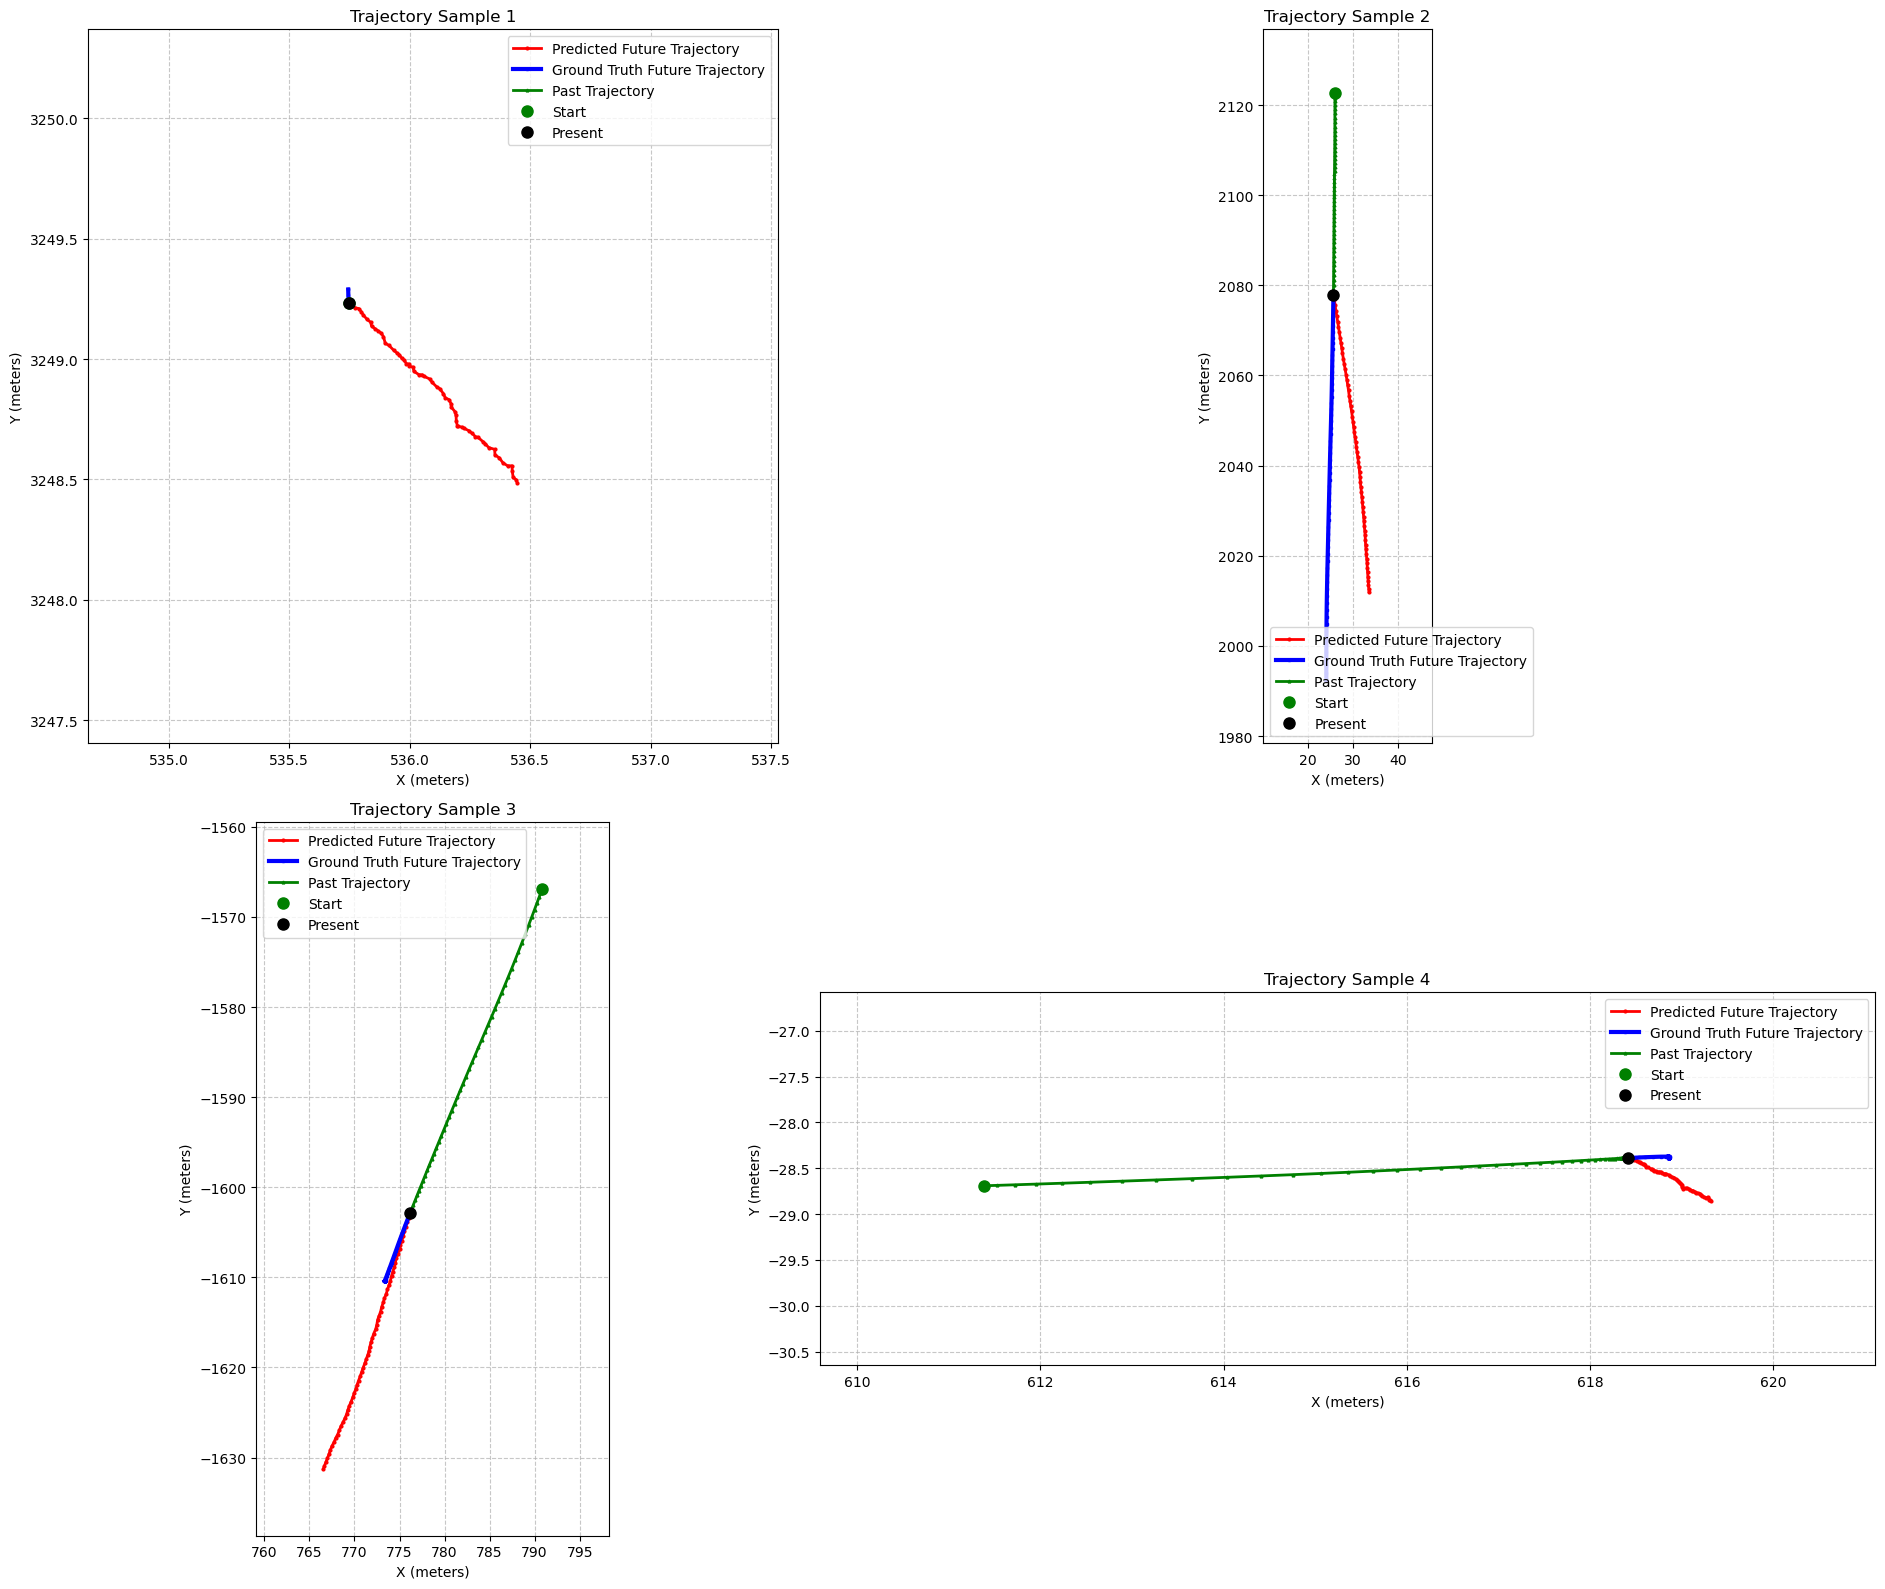


Sample 0 debugging:
Past trajectory first 5 points:
[[ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]]
Past trajectory last 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]
Predicted trajectory first 5 points:
[[ 535.7558 3249.2246]
 [ 535.7742 3249.2126]
 [ 535.7885 3249.2097]
 [ 535.7995 3249.1956]
 [ 535.8072 3249.1829]]
GT trajectory first 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]


In [120]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# ---- Load Model ----
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
model.load_state_dict(best_model2)
model.eval()

# ---- Plotting Function ----
def plot_trajectory(ax, past, pred, gt, title=None):
    ax.cla()
    
    # Plot trajectories
    ax.plot(pred[:, 0], pred[:, 1], color='red', label='Predicted Future Trajectory', linewidth=2, marker='o', markersize=2)
    ax.plot(gt[:, 0], gt[:, 1], color='blue', label='Ground Truth Future Trajectory', linewidth=3, marker='s', markersize=2)
    ax.plot(past[:, 0], past[:, 1], color='green', label='Past Trajectory', linewidth=2, marker='^', markersize=2)
    
    # Mark start and end points
    ax.plot(past[0, 0], past[0, 1], 'go', markersize=8, label='Start')
    ax.plot(past[-1, 0], past[-1, 1], 'ko', markersize=8, label='Present')
    
    # Set axis limits with some padding
    all_x = np.concatenate([past[:, 0], pred[:, 0], gt[:, 0]])
    all_y = np.concatenate([past[:, 1], pred[:, 1], gt[:, 1]])
    
    x_range = all_x.max() - all_x.min()
    y_range = all_y.max() - all_y.min()
    padding = max(x_range, y_range) * 0.1 + 1  # Add some padding
    
    ax.set_xlim(all_x.min() - padding, all_x.max() + padding)
    ax.set_ylim(all_y.min() - padding, all_y.max() + padding)
    
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

# ---- Inference + Collection ----
samples = []
dt = 0.1

with torch.no_grad():
    for b, batch in enumerate(val_dataloader):
        if b in [0, 1]:
            continue  # Skip the first batch
    
        if len(samples) >= 4:
            break
            
        batch = batch.to(device)
        scale = batch.scale.view(-1, 1, 1).cpu().numpy()  # (B, 1, 1)
        origin = batch.origin.cpu().numpy()  # This might be (B, 2) instead of (B, 1, 2)
        
        # Debug: Print actual shapes
        print(f'Batch {b}: origin shape: {origin.shape}, scale shape: {scale.shape}')
        print(f'Origin array:\n{origin}')
        print(f'Scale array:\n{scale}')
        
        # Get predictions
        gt_vel = batch.y.view(batch.num_graphs, 60, 4)[..., 2:4] * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        pred_vel = model(batch) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        
        # Convert to CPU numpy
        gt_vel = gt_vel.cpu().numpy()
        pred_vel = pred_vel.cpu().numpy()
        
        for i in range(batch.num_graphs):
            if len(samples) >= 4:
                break
                
            # Extract data for this sample - FIXED INDEXING
            current_scale = scale[i, 0, 0]  # scalar
            
            # Fix the origin indexing based on actual shape
            if len(origin.shape) == 3:  # (B, 1, 2)
                current_origin = origin[i, 0, :]  # (2,)
            elif len(origin.shape) == 2:  # (B, 2)
                current_origin = origin[i, :]  # (2,)
            else:
                print(f"Unexpected origin shape: {origin.shape}")
                continue
            
            print(f'Sample {i}: origin={current_origin}, scale={current_scale}')
            
            # Get past trajectory for ego agent (agent 0)
            # batch.x shape: (total_nodes, 50, 5) where 5 = [x, y, vx, vy, heading]
            # We need to extract the ego agent's trajectory for sample i
            
            # Calculate node indices for sample i
            start_idx = i * 50  # Assuming 50 agents per scene
            end_idx = start_idx + 50
            
            ego_idx = start_idx  # Ego agent is the first agent in each scene
            past_trajectory = batch.x[ego_idx, :, :2].cpu().numpy()  # (50, 2) - positions only
            
            # Denormalize past trajectory
            past_trajectory = past_trajectory * current_scale + current_origin
            
            print(f'scene: {i}')
            print(f'past_trajectory: {past_trajectory}')
            
            # Get velocities for future prediction
            pred_vel_sample = pred_vel[i]  # (60, 2)
            gt_vel_sample = gt_vel[i]    # (60, 2)
            
            print(f'Past trajectory shape: {past_trajectory.shape}')
            print(f'Past trajectory range: x=[{past_trajectory[:, 0].min():.1f}, {past_trajectory[:, 0].max():.1f}], y=[{past_trajectory[:, 1].min():.1f}, {past_trajectory[:, 1].max():.1f}]')
            
            # Integrate future positions from velocities
            # Start from the last position of past trajectory
            last_pos = past_trajectory[-1]  # (2,)
            
            # Predicted future positions
            pred_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = pred_positions[-1] + pred_vel_sample[t] * dt
                pred_positions.append(next_pos)
            pred_positions = np.array(pred_positions[1:])  # Remove initial position, keep 60 future positions
            
            # Ground truth future positions
            gt_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = gt_positions[-1] + gt_vel_sample[t] * dt
                gt_positions.append(next_pos)
            gt_positions = np.array(gt_positions[1:])  # Remove initial position, keep 60 future positions
            
            print(f'Pred positions shape: {pred_positions.shape}')
            print(f'GT positions shape: {gt_positions.shape}')
            print(f'Pred positions range: x=[{pred_positions[:, 0].min():.1f}, {pred_positions[:, 0].max():.1f}], y=[{pred_positions[:, 1].min():.1f}, {pred_positions[:, 1].max():.1f}]')
            
            # Store sample
            samples.append({
                'past': past_trajectory,
                'pred': pred_positions,
                'gt': gt_positions,
            })
            
            print(f'Added sample {len(samples)}, total samples: {len(samples)}')

print(f'\nCollected {len(samples)} samples')
if len(samples) > 0:
    print(f'Sample 0 shapes: past={samples[0]["past"].shape}, pred={samples[0]["pred"].shape}, gt={samples[0]["gt"].shape}')

# ---- Plot ----
if len(samples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    plot_samples = samples[:4] if len(samples) >= 4 else samples
    
    for i, sample in enumerate(plot_samples):
        print(f'Plotting sample {i}')
        print(f'  Past range: x=[{sample["past"][:, 0].min():.1f}, {sample["past"][:, 0].max():.1f}], y=[{sample["past"][:, 1].min():.1f}, {sample["past"][:, 1].max():.1f}]')
        print(f'  Pred range: x=[{sample["pred"][:, 0].min():.1f}, {sample["pred"][:, 0].max():.1f}], y=[{sample["pred"][:, 1].min():.1f}, {sample["pred"][:, 1].max():.1f}]')
        print(f'  GT range: x=[{sample["gt"][:, 0].min():.1f}, {sample["gt"][:, 0].max():.1f}], y=[{sample["gt"][:, 1].min():.1f}, {sample["gt"][:, 1].max():.1f}]')
        
        plot_trajectory(axes[i], sample['past'], sample['pred'], sample['gt'], title=f"Trajectory Sample {i+1}")
    
    # Hide unused subplots
    for i in range(len(plot_samples), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No samples collected - check your data processing!")

# Additional debugging: Print some sample values
if len(samples) > 0:
    sample = samples[0]
    print(f"\nSample 0 debugging:")
    print(f"Past trajectory first 5 points:\n{sample['past'][:5]}")
    print(f"Past trajectory last 5 points:\n{sample['past'][-5:]}")
    print(f"Predicted trajectory first 5 points:\n{sample['pred'][:5]}")
    print(f"GT trajectory first 5 points:\n{sample['gt'][:5]}")

# Additional debugging function to understand your data structure better
def debug_batch_structure(batch):
    """Helper function to understand the batch structure"""
    print("\n=== BATCH STRUCTURE DEBUG ===")
    print(f"batch.num_graphs: {batch.num_graphs}")
    print(f"batch.x.shape: {batch.x.shape}")
    print(f"batch.y.shape: {batch.y.shape}")
    print(f"batch.scale.shape: {batch.scale.shape}")
    print(f"batch.origin.shape: {batch.origin.shape}")
    
    if hasattr(batch, 'batch'):
        print(f"batch.batch.shape: {batch.batch.shape}")
        print(f"batch.batch unique values: {torch.unique(batch.batch)}")
    
    print("Origin values:")
    print(batch.origin.cpu().numpy())
    print("Scale values:")
    print(batch.scale.cpu().numpy())
    print("===============================\n")

# Uncomment the line below to run the debug function on your first batch
# debug_batch_structure(next(iter(val_dataloader)).to(device))

Batch 2: origin shape: (32, 2), scale shape: (32, 1, 1)
Origin array:
[[  535.74615   3249.2341  ]
 [   25.715364  2077.918   ]
 [  776.16876  -1602.885   ]
 [  618.4111     -28.385862]
 [11756.716     5224.448   ]
 [  -99.0203    -205.09248 ]
 [ 5589.5454    2166.4856  ]
 [  576.5858    1281.5502  ]
 [  346.50455  -1478.2499  ]
 [ 3747.403    -2031.8069  ]
 [ 2759.4443   -1484.7734  ]
 [ 5432.695     1797.2394  ]
 [-1447.3081    1800.8248  ]
 [ 9846.43      3277.9082  ]
 [ 5581.5996     752.5961  ]
 [ 9993.361     5121.5425  ]
 [ -814.305    -2415.3994  ]
 [ 4804.9727    3348.715   ]
 [   50.00897   -679.9272  ]
 [  163.55113   -148.68156 ]
 [ 6340.244     -137.16518 ]
 [  641.7041    -908.7565  ]
 [ 7986.2783    3285.629   ]
 [ -812.3995   -1081.4679  ]
 [  326.5171    -879.4236  ]
 [  382.07574    816.5598  ]
 [  712.54254  -1604.3905  ]
 [ 6587.951     1235.543   ]
 [ -426.26453    405.36816 ]
 [ 6470.7017    1761.914   ]
 [ 4183.4834    2726.129   ]
 [  693.46783   1000.6648  ]]
S

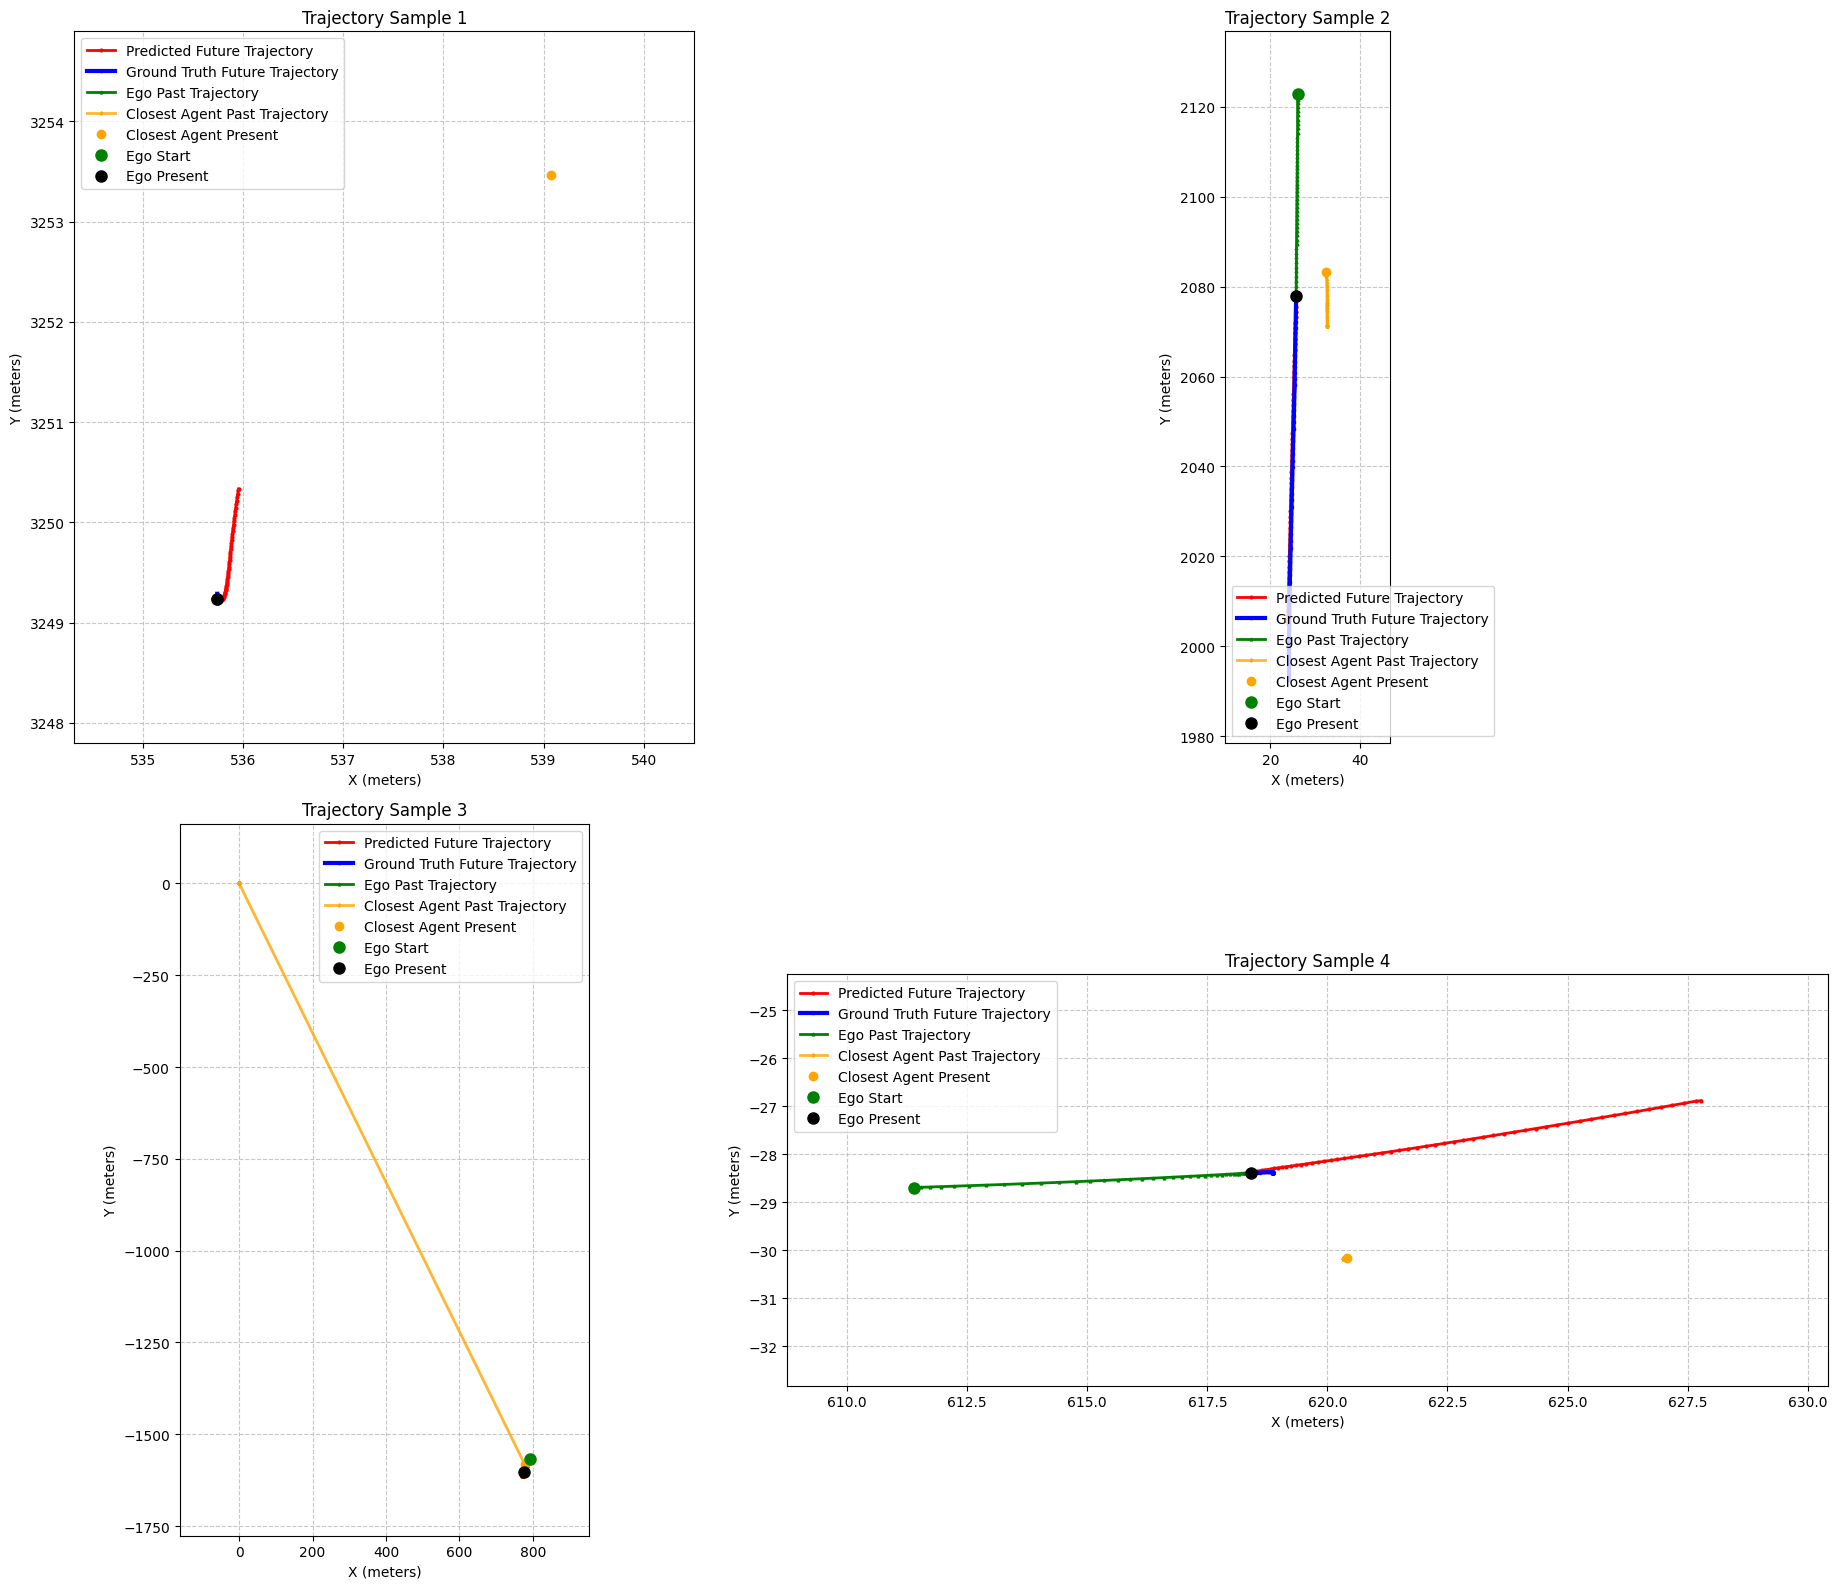


Sample 0 debugging:
Past trajectory first 5 points:
[[ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]
 [ 535.7463 3249.2341]]
Past trajectory last 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]
Predicted trajectory first 5 points:
[[ 535.75116 3249.2307 ]
 [ 535.756   3249.228  ]
 [ 535.7607  3249.2258 ]
 [ 535.76514 3249.224  ]
 [ 535.76953 3249.2231 ]]
GT trajectory first 5 points:
[[ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]
 [ 535.74615 3249.2341 ]]


In [100]:


# ---- Load Model ----
best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
model.load_state_dict(best_model2)
model.eval()

# ---- Plotting Function ----
def plot_trajectory(ax, past, pred, gt, closest_agent_past=None, title=None):
    ax.cla()
    
    # Plot trajectories
    ax.plot(pred[:, 0], pred[:, 1], color='red', label='Predicted Future Trajectory', linewidth=2, marker='o', markersize=2)
    ax.plot(gt[:, 0], gt[:, 1], color='blue', label='Ground Truth Future Trajectory', linewidth=3, marker='s', markersize=2)
    ax.plot(past[:, 0], past[:, 1], color='green', label='Ego Past Trajectory', linewidth=2, marker='^', markersize=2)
    
    # Plot closest agent trajectory if provided
    if closest_agent_past is not None:
        ax.plot(closest_agent_past[:, 0], closest_agent_past[:, 1], color='orange', label='Closest Agent Past Trajectory', 
                linewidth=2, marker='d', markersize=2, alpha=0.8)
        # Mark closest agent's final position
        ax.plot(closest_agent_past[-1, 0], closest_agent_past[-1, 1], 'o', color='orange', markersize=6, label='Closest Agent Present')
    
    # Mark start and end points for ego
    ax.plot(past[0, 0], past[0, 1], 'go', markersize=8, label='Ego Start')
    ax.plot(past[-1, 0], past[-1, 1], 'ko', markersize=8, label='Ego Present')
    
    # Set axis limits with some padding
    all_x = np.concatenate([past[:, 0], pred[:, 0], gt[:, 0]])
    all_y = np.concatenate([past[:, 1], pred[:, 1], gt[:, 1]])
    
    # Include closest agent in axis calculations if available
    if closest_agent_past is not None:
        all_x = np.concatenate([all_x, closest_agent_past[:, 0]])
        all_y = np.concatenate([all_y, closest_agent_past[:, 1]])
    
    x_range = all_x.max() - all_x.min()
    y_range = all_y.max() - all_y.min()
    padding = max(x_range, y_range) * 0.1 + 1  # Add some padding
    
    ax.set_xlim(all_x.min() - padding, all_x.max() + padding)
    ax.set_ylim(all_y.min() - padding, all_y.max() + padding)
    
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    if title:
        ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('equal', adjustable='box')

# ---- Inference + Collection ----
samples = []
dt = 0.1

with torch.no_grad():
    for b, batch in enumerate(val_dataloader):
        if b in [0, 1]:
            continue  # Skip the first batch
        if len(samples) >= 4:
            break
            
        batch = batch.to(device)
        scale = batch.scale.view(-1, 1, 1).cpu().numpy()  # (B, 1, 1)
        origin = batch.origin.cpu().numpy()  # This might be (B, 2) instead of (B, 1, 2)
        
        # Debug: Print actual shapes
        print(f'Batch {b}: origin shape: {origin.shape}, scale shape: {scale.shape}')
        print(f'Origin array:\n{origin}')
        print(f'Scale array:\n{scale}')
        
        # Get predictions
        gt_vel = batch.y.view(batch.num_graphs, 60, 2) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        pred_vel = model(batch) * batch.scale.view(-1, 1, 1)  # (B, 60, 2)
        
        # Convert to CPU numpy
        gt_vel = gt_vel.cpu().numpy()
        pred_vel = pred_vel.cpu().numpy()
        
        for i in range(batch.num_graphs):
            if len(samples) >= 4:
                break
                
            # Extract data for this sample - FIXED INDEXING
            current_scale = scale[i, 0, 0]  # scalar
            
            # Fix the origin indexing based on actual shape
            if len(origin.shape) == 3:  # (B, 1, 2)
                current_origin = origin[i, 0, :]  # (2,)
            elif len(origin.shape) == 2:  # (B, 2)
                current_origin = origin[i, :]  # (2,)
            else:
                print(f"Unexpected origin shape: {origin.shape}")
                continue
            
            print(f'Sample {i}: origin={current_origin}, scale={current_scale}')
            
            # Get past trajectory for ego agent (agent 0)
            # batch.x shape: (total_nodes, 50, 5) where 5 = [x, y, vx, vy, heading]
            # We need to extract the ego agent's trajectory for sample i
            
            # Calculate node indices for sample i
            start_idx = i * 50  # Assuming 50 agents per scene
            end_idx = start_idx + 50
            
            ego_idx = start_idx  # Ego agent is the first agent in each scene
            past_trajectory = batch.x[ego_idx, :, :2].cpu().numpy()  # (50, 2) - positions only
            
            # Denormalize past trajectory
            past_trajectory = past_trajectory * current_scale + current_origin
            
            # Find closest agent at the 50th timestep (last timestep)
            ego_final_pos = past_trajectory[-1]  # Position at timestep 50
            closest_agent_idx = None
            min_distance = float('inf')
            
            # Check all other agents in this scene
            for agent_idx in range(start_idx + 1, end_idx):  # Skip ego agent (start_idx)
                if agent_idx < batch.x.shape[0]:  # Make sure we don't go out of bounds
                    agent_final_pos = batch.x[agent_idx, -1, :2].cpu().numpy()  # Last timestep position
                    agent_final_pos = agent_final_pos * current_scale + current_origin  # Denormalize
                    
                    # Calculate distance to ego at final timestep
                    distance = np.linalg.norm(ego_final_pos - agent_final_pos)
                    if distance < min_distance:
                        min_distance = distance
                        closest_agent_idx = agent_idx
            
            # Get closest agent's past trajectory
            closest_agent_past = None
            if closest_agent_idx is not None:
                closest_agent_past = batch.x[closest_agent_idx, :, :2].cpu().numpy()  # (50, 2)
                closest_agent_past = closest_agent_past * current_scale + current_origin  # Denormalize
                print(f'Closest agent distance: {min_distance:.2f}m at final timestep')
            else:
                print('No closest agent found')
            
            # Get velocities for future prediction
            pred_vel_sample = pred_vel[i]  # (60, 2)
            gt_vel_sample = gt_vel[i]    # (60, 2)
            
            print(f'Past trajectory shape: {past_trajectory.shape}')
            print(f'Past trajectory range: x=[{past_trajectory[:, 0].min():.1f}, {past_trajectory[:, 0].max():.1f}], y=[{past_trajectory[:, 1].min():.1f}, {past_trajectory[:, 1].max():.1f}]')
            
            # Integrate future positions from velocities
            # Start from the last position of past trajectory
            last_pos = past_trajectory[-1]  # (2,)
            
            # Predicted future positions
            pred_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = pred_positions[-1] + pred_vel_sample[t] * dt
                pred_positions.append(next_pos)
            pred_positions = np.array(pred_positions[1:])  # Remove initial position, keep 60 future positions
            
            # Ground truth future positions
            gt_positions = [last_pos.copy()]
            for t in range(60):
                next_pos = gt_positions[-1] + gt_vel_sample[t] * dt
                gt_positions.append(next_pos)
            gt_positions = np.array(gt_positions[1:])  # Remove initial position, keep 60 future positions
            
            print(f'Pred positions shape: {pred_positions.shape}')
            print(f'GT positions shape: {gt_positions.shape}')
            print(f'Pred positions range: x=[{pred_positions[:, 0].min():.1f}, {pred_positions[:, 0].max():.1f}], y=[{pred_positions[:, 1].min():.1f}, {pred_positions[:, 1].max():.1f}]')
            
            # Store sample
            samples.append({
                'past': past_trajectory,
                'pred': pred_positions,
                'gt': gt_positions,
                'closest_agent_past': closest_agent_past,
            })
            
            print(f'Added sample {len(samples)}, total samples: {len(samples)}')

print(f'\nCollected {len(samples)} samples')
if len(samples) > 0:
    print(f'Sample 0 shapes: past={samples[0]["past"].shape}, pred={samples[0]["pred"].shape}, gt={samples[0]["gt"].shape}')

# ---- Plot ----
if len(samples) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    plot_samples = samples[:4] if len(samples) >= 4 else samples
    
    for i, sample in enumerate(plot_samples):
        print(f'Plotting sample {i}')
        print(f'  Past range: x=[{sample["past"][:, 0].min():.1f}, {sample["past"][:, 0].max():.1f}], y=[{sample["past"][:, 1].min():.1f}, {sample["past"][:, 1].max():.1f}]')
        print(f'  Pred range: x=[{sample["pred"][:, 0].min():.1f}, {sample["pred"][:, 0].max():.1f}], y=[{sample["pred"][:, 1].min():.1f}, {sample["pred"][:, 1].max():.1f}]')
        print(f'  GT range: x=[{sample["gt"][:, 0].min():.1f}, {sample["gt"][:, 0].max():.1f}], y=[{sample["gt"][:, 1].min():.1f}, {sample["gt"][:, 1].max():.1f}]')
        
        plot_trajectory(axes[i], sample['past'], sample['pred'], sample['gt'], 
                       closest_agent_past=sample['closest_agent_past'], 
                       title=f"Trajectory Sample {i+1}")
    
    # Hide unused subplots
    for i in range(len(plot_samples), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No samples collected - check your data processing!")

# Additional debugging: Print some sample values
if len(samples) > 0:
    sample = samples[0]
    print(f"\nSample 0 debugging:")
    print(f"Past trajectory first 5 points:\n{sample['past'][:5]}")
    print(f"Past trajectory last 5 points:\n{sample['past'][-5:]}")
    print(f"Predicted trajectory first 5 points:\n{sample['pred'][:5]}")
    print(f"GT trajectory first 5 points:\n{sample['gt'][:5]}")

# Additional debugging function to understand your data structure better
def debug_batch_structure(batch):
    """Helper function to understand the batch structure"""
    print("\n=== BATCH STRUCTURE DEBUG ===")
    print(f"batch.num_graphs: {batch.num_graphs}")
    print(f"batch.x.shape: {batch.x.shape}")
    print(f"batch.y.shape: {batch.y.shape}")
    print(f"batch.scale.shape: {batch.scale.shape}")
    print(f"batch.origin.shape: {batch.origin.shape}")
    
    if hasattr(batch, 'batch'):
        print(f"batch.batch.shape: {batch.batch.shape}")
        print(f"batch.batch unique values: {torch.unique(batch.batch)}")
    
    print("Origin values:")
    print(batch.origin.cpu().numpy())
    print("Scale values:")
    print(batch.scale.cpu().numpy())
    print("===============================\n")

# Uncomment the line below to run the debug function on your first batch
# debug_batch_structure(next(iter(val_dataloader)).to(device))

# Final Pred

In [131]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_attn_noise.csv', index=True)
# output_df.to_csv('submission_lstm_simple_auto8_largerhidden.csv', index=True)

(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50, 50, 9)
(50,